# Import Necessary Packages

In [12]:
# General
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
from collections import Counter
import sys
import os
import datetime
from scipy.spatial.distance import hamming
import seaborn as sb
import scipy as sp
sys.path.insert(0, "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/causal_discovery_packages/causal_discovery_for_time_series_master")


# Global Variables

In [13]:
alpha = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9,1]
# alpha_dynotears = np.logspace(-5,5,10)
alpha_dynotears = alpha

alpha_level_pcmci = [1e-20,1e-18,1e-16,1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2 ]
pc_alpha = 1

tau_max = 2
tau_min = 0

bic_coef_all = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9,1]
mvgc_alpha = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

pc_alpha_pcmciplus = [0.01, 0.2, 0.4, 0.6, 0.8 , 1]

# parcorr = ParCorr(significance='analytic')

num_simple_networks = 9
num_rep_MTL = 23
num_rep_macaque = 60
num_rep_simple_net = 60
Net = 0

Net_labels = ['Net %d'%i for i in range(1,num_simple_networks+1)]

# Functions

In [14]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    for varName in Data:
        globals()[varName] = Data[varName]  

# this function reads the output txt file from causal-cmd software 
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]
    

def tetrad_graph_parser(filename, ground_truth = 0):

    k = 0
    with open(filename) as f:
        for line in f:
            if line == "Graph Nodes:\n":
                nodes_line = k + 1
            if line == "Graph Edges:\n":
                edges_line = k + 1
            if line[0:5] == "Start":
                start_time_line = k
            if line[0:3] == "End":
                end_time_line = k
            k += 1 
    with open(filename) as f:
        all_lines = f.readlines()

    if ground_truth == 1:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(",")
    else:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(";")
        
    graph_edges = all_lines[edges_line:]

    num_nodes = len(graph_nodes)
    num_edges = len(graph_edges)


# calculate the execution time 
    execution_time = 0

    if ground_truth == 0:

        start_temp = all_lines[start_time_line][13:].replace("\n","").split(",")
        end_temp = all_lines[end_time_line][12:].replace("\n","").split(",")

        start_date = start_temp[1].split(" ")
        end_date = end_temp[1].split(" ")

        start_month = monthToNum(start_date[1])
        end_month = monthToNum(end_date[1])

        start_day = int(start_date[2])
        end_day = int(end_date[2])

        start_year = int(start_temp[2].split(" ")[1])
        end_year = int(end_temp[2].split(" ")[1])

        start_time = start_temp[2].split(" ")[2].split(":")
        end_time = end_temp[2].split(" ")[2].split(":")
        
        start_am_pm = start_temp[2].split(" ")[3]
        end_am_pm = end_temp[2].split(" ")[3]

        start_hour = int(start_time[0])
        start_min = int(start_time[1])
        start_second = int(start_time[2])

        end_hour = int(end_time[0])
        end_min = int(end_time[1])
        end_second = int(end_time[2])

        if (start_am_pm == 'PM') and (start_hour != 12):
            start_hour = start_hour + 12

        if (end_am_pm == 'PM') and (end_hour != 12):
            end_hour = end_hour + 12
        
        if (start_am_pm == 'AM') and (start_hour == 12):
            start_hour = 0

        if (end_am_pm == 'AM') and (end_hour == 12):
            end_hour = 0


        dt1 = datetime.datetime(start_year,start_month,start_day,start_hour,start_min,start_second) 
        dt2 = datetime.datetime(end_year,end_month,end_day,end_hour,end_min,end_second) 
        tdelta = dt2 - dt1 
        
        execution_time = tdelta.total_seconds()

        print(dt1, dt2,execution_time)


        # execution_time = end_total_sec - start_total_sec 
        
    graph_matrix = np.zeros((num_nodes,num_nodes))

    for e in range(0, num_edges):

        current_edge = graph_edges[e].replace(str(e+1)+".","").replace("\n","").replace(" ","").split("-->")
        i = int(current_edge[0].replace('X',''))-1
        j = int(current_edge[1].replace('X',''))-1

        graph_matrix[i,j] = 1

    return graph_nodes, graph_edges, graph_matrix, execution_time

# This function plot a directional graph from a binary matrix
def plot_graph(matrix, nodes, title):

    node_color = 'lightblue'
    node_size = 3000
    font_size = 32
    edge_width = 5

    G = nx.from_numpy_matrix(matrix, create_using = nx.MultiDiGraph())  

    pos=nx.circular_layout(G) 

    nx.draw_networkx(G,  labels = dict(zip(range(len(nodes)), range(1,len(nodes)+1))), with_labels = True, node_size = node_size, node_color=node_color, font_size = font_size, pos = pos, width = edge_width)

    # labels = nx.draw_networkx_labels(G, pos= pos)
    plt.title(title, fontsize = 44)

# This function summarizes a time lag graph to a summary graph by combining the edges accross the lags
def summarize_across_lags(time_lag_graph):

    num_vars = time_lag_graph.shape[0]
    num_lags = time_lag_graph.shape[2]

    summary_graph = [['' for t in range(0, num_vars)] for i in range(0, num_vars)]

    adjacency_binary_matrix = np.zeros((num_vars, num_vars))
    orientation_binary_matrix = np.zeros((num_vars, num_vars))

    for i in range(0,num_vars):
        for j in range(0,num_vars):

            edges_all_lags  = time_lag_graph[i,j,:]

            if '-->' in edges_all_lags:
                summary_graph[i][j] = '-->'

                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 1

            elif ('-->' not in edges_all_lags and 'o-o' in edges_all_lags):
                summary_graph[i][j] = 'o-o'
                
                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 0

            else:
                summary_graph[i][j] = ''
                
                adjacency_binary_matrix[i,j] = 0
                orientation_binary_matrix[i,j] = 0

    
    return summary_graph, adjacency_binary_matrix, orientation_binary_matrix

def find_tpr_fpr_v2(true_graph_matrix, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score

# This function creats a time lag graph from the dictionary
def make_time_lag_graph_from_dict(graph_dict, tau_max):
    dict_vars = graph_dict.keys()
    num_vars = len(dict_vars)

    time_lag_graph = [[['' for t in range(0, tau_max+1)] for j in range(0,num_vars)] for i in range(0, num_vars)]

    for v1 in range(0,num_vars):
        var_name = 'X%d'%(v1+1)
        var_time_lags = graph_dict[var_name]

        for v2 in range(0,num_vars):
            for t in range(0,tau_max+1):
                if ('X%d'%(v2+1),-t) in var_time_lags:
                    time_lag_graph[v2][v1][t] = '-->'
                else:
                    time_lag_graph[v2][v1][t] = ''

    return time_lag_graph


# The following function computes TPR,FPR, Recall, Precision, and F1 score for an estimated graph
def find_tpr_fpr(true_graph_matrix, estimated_graph_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score

# The following functions are defined to estimate the binary matrix from a PAG
def find_binary_matrix_lag_non_zero_combined(PAG):

        PAG_non_zero_lags = PAG[:,:,1:]
        m = PAG_non_zero_lags.shape[0]
        num_lags = PAG_non_zero_lags.shape[2]

        PAG_non_zero_lags_binary = np.zeros((m,m, num_lags))
        PAG_non_zero_lags_binary[PAG_non_zero_lags == '-->'] = 1

        binary_matrix = np.sum(PAG_non_zero_lags_binary, axis = 2)
        binary_matrix[binary_matrix >=1] = 1

        return binary_matrix

def summarize_across_all_lags(time_lag_graph):

    num_vars = time_lag_graph.shape[0]
    num_lags = time_lag_graph.shape[2]

    summary_graph = [['' for t in range(0, num_vars)] for i in range(0, num_vars)]

    binary_matrix = np.zeros((num_vars, num_vars))
    for i in range(0,num_vars):
        for j in range(0,num_vars):

            edges_all_lags  = time_lag_graph[i,j,:]

            if '-->' in edges_all_lags:
                summary_graph[i][j] = '-->'

                binary_matrix[i,j] = 1

            else:
                summary_graph[i][j] = ''
                
                binary_matrix[i,j] = 0

    
    return binary_matrix

# Load Saved Results

In [15]:
import_npz('PCMCI_all_simple_nets.npz')
import_npz('PCMCIPlus_all_simple_nets.npz')
import_npz('Dynotears_all_simple_nets.npz')
import_npz('Varlingam_all_simple_nets.npz')
import_npz('FASK_all_simple_nets.npz') 
import_npz('DGlearn_all_simple_nets.npz')
import_npz('mvgc_all_simple_nets.npz')

# Load Real and Simulated Data


## Simulated Simple Networks: Net 1, Net 2,..., Net 9

In [16]:
all_net_nodes_dict = {}
simple_net_all_data = [0]*num_simple_networks

for n in range(0,num_simple_networks):
    path_to_Simple_Net = "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/1_Simple_Networks/Network"+str(n+1)+"_amp/data_fslfilter_concat"

    if n == 7 or n == 8:
       path_to_Simple_Net = "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/1_Simple_Networks/Network"+str(n+1)+"_amp_amp/data_fslfilter_concat"

    simple_net = [0]*num_rep_simple_net

    for i in range (1,num_rep_simple_net + 1):
        if i <= 9:
            current_str = "0"+str(i)
        elif 10 <= i:
            current_str = str(i)

        simple_net [i-1]  = pd.read_csv(path_to_Simple_Net+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t')

    num_nodes_temp = simple_net [i-1].shape[1]
    nodes_simple_net = ['X%d'%i for i in range(1,num_nodes_temp+1)]
    all_net_nodes_dict[str(n+1)]= nodes_simple_net

    simple_net_all_data[n] = simple_net

    print('nodes in simple network %d :'%(n+1),nodes_simple_net)

nodes in simple network 1 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 2 : ['X1', 'X2', 'X3', 'X4', 'X5']


nodes in simple network 3 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 4 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
nodes in simple network 5 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 6 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
nodes in simple network 7 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
nodes in simple network 8 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
nodes in simple network 9 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']


## Read Ground Truth Graphs


In [17]:
path_to_ground_truth = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Tetrad_Simulations/Causal_cmd/Ground_Truth_Graphs/'

ground_truth_nodes_all_networks = [0]*num_simple_networks
ground_truth_edges_all_networks = [0]* num_simple_networks
ground_truth_graph_matrix_all_networks = [0]*num_simple_networks

for n in range(0,num_simple_networks):
    filename = path_to_ground_truth + 'Network%d_amp.txt'%(n+1)
    nodes, edges, graph_matrix, execution_time = tetrad_graph_parser(filename, ground_truth = 1)
    print('Simple Network %d:'%(n+1),nodes)

    ground_truth_nodes_all_networks[n] = nodes
    ground_truth_edges_all_networks[n] = edges
    ground_truth_graph_matrix_all_networks[n] = graph_matrix

net_size_all = np.zeros((num_simple_networks,1))
net_density_all = np.zeros((num_simple_networks,1))
for n in range(0,num_simple_networks):
    net_size_all[n] = len(ground_truth_nodes_all_networks[n])
    net_density_all[n] = np.mean(ground_truth_graph_matrix_all_networks[n])


Simple Network 1: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 2: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 3: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 4: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
Simple Network 5: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 6: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
Simple Network 7: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
Simple Network 8: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
Simple Network 9: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']


# Causal Discovery Methods

## FASK

##### Run FASK using system command (causal-cmd)

In [18]:
# for n in range(1, num_simple_networks+1):

# 	for a in range(0,len(alpha)):
		
# 		for r in range(1, num_rep_simple_net+1):

# 			path_to_causal_cmd = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/causal_discovery_packages/causal-cmd-1.3.0-distribution/causal-cmd-1.3.0/causal-cmd-1.3.0-jar-with-dependencies.jar'

# 			if r < 10:
# 				rep_str = '0'+str(r)
# 			else:
# 				rep_str = str(r)

# 			if n == 8 or n == 9: 

# 				path_to_data = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/1_Simple_Networks/Network%d_amp_amp/data_fslfilter_concat/concat_BOLDfslfilter_%s.txt'%(n,rep_str)
# 			else: 
# 				path_to_data = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/1_Simple_Networks/Network%d_amp/data_fslfilter_concat/concat_BOLDfslfilter_%s.txt'%(n,rep_str)

# 			path_to_fask_output = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Tetrad_Simulations/Causal_cmd/Net%d'%n
# 			os.system('java -jar '+path_to_causal_cmd+ ' --algorithm fask --alpha '+ str(alpha[a])+ ' --data-type continuous --dataset '+path_to_data+' --out '+path_to_fask_output+' --prefix '+ 'Net%d'%n +'-'+ str(alpha[a])+'-%s'%rep_str+' --delimiter tab --test cci-test --verbose No')

##### Read FASK outputs

In [19]:
estimated_FASK_nodes_all_networks = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
estimated_FASK_edges_all_networks = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0, num_simple_networks)]
fask_link_matrix_all_simple_net = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0, num_simple_networks)]
fask_simple_net_execution_time = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        if r < 9:
            rep = '0'+str(r+1)
        else:
            rep = str(r+1)

        for a in range(0, len(alpha)):

            filename = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Tetrad_Simulations/Causal_cmd/Net%d/Net%d'%(n+1, n+1)+'-'+str(alpha[a])+'-'+rep+'.txt'
            print('Network',n+1,'Repetition:',r+1,'Alpha:',alpha[a])

            nodes, edges, graph_matrix, execution_time = tetrad_graph_parser(filename, ground_truth = 0)

            estimated_FASK_nodes_all_networks[n][r][a] = nodes
            estimated_FASK_edges_all_networks[n][r][a] = edges
            fask_link_matrix_all_simple_net[n][r][a] = graph_matrix
            fask_simple_net_execution_time[n][r][a] = execution_time

Network 1 Repetition: 1 Alpha: 0.005
2022-08-23 14:09:22 2022-08-23 14:09:39 17.0
Network 1 Repetition: 1 Alpha: 0.01
2022-07-11 13:50:46 2022-07-11 13:51:04 18.0
Network 1 Repetition: 1 Alpha: 0.05
2022-07-11 14:11:43 2022-07-11 14:12:06 23.0
Network 1 Repetition: 1 Alpha: 0.1
2022-07-11 14:35:45 2022-07-11 14:36:09 24.0
Network 1 Repetition: 1 Alpha: 0.15
2022-07-11 15:01:16 2022-07-11 15:01:39 23.0
Network 1 Repetition: 1 Alpha: 0.3
2022-07-11 15:27:53 2022-07-11 15:28:20 27.0
Network 1 Repetition: 1 Alpha: 0.5
2022-07-11 15:57:03 2022-07-11 15:57:30 27.0
Network 1 Repetition: 1 Alpha: 0.7
2022-07-11 16:27:38 2022-07-11 16:28:09 31.0
Network 1 Repetition: 1 Alpha: 0.9
2022-07-11 16:59:17 2022-07-11 16:59:47 30.0
Network 1 Repetition: 1 Alpha: 1
2022-07-11 17:31:00 2022-07-11 17:31:30 30.0
Network 1 Repetition: 2 Alpha: 0.005
2022-07-11 13:26:18 2022-07-11 13:26:52 34.0
Network 1 Repetition: 2 Alpha: 0.01
2022-07-11 13:51:06 2022-07-11 13:51:31 25.0
Network 1 Repetition: 2 Alpha: 0.0

2022-07-18 19:31:49 2022-07-18 19:32:19 30.0
Network 5 Repetition: 39 Alpha: 0.005
2022-07-18 16:21:16 2022-07-18 16:21:24 8.0
Network 5 Repetition: 39 Alpha: 0.01
2022-07-18 16:31:29 2022-07-18 16:31:37 8.0
Network 5 Repetition: 39 Alpha: 0.05
2022-07-18 16:43:02 2022-07-18 16:43:10 8.0
Network 5 Repetition: 39 Alpha: 0.1
2022-07-18 16:56:38 2022-07-18 16:56:47 9.0
Network 5 Repetition: 39 Alpha: 0.15
2022-07-18 17:12:33 2022-07-18 17:12:42 9.0
Network 5 Repetition: 39 Alpha: 0.3
2022-07-18 17:33:25 2022-07-18 17:33:51 26.0
Network 5 Repetition: 39 Alpha: 0.5
2022-07-18 17:59:51 2022-07-18 18:00:17 26.0
Network 5 Repetition: 39 Alpha: 0.7
2022-07-18 18:29:45 2022-07-18 18:30:15 30.0
Network 5 Repetition: 39 Alpha: 0.9
2022-07-18 19:00:57 2022-07-18 19:01:27 30.0
Network 5 Repetition: 39 Alpha: 1
2022-07-18 19:32:20 2022-07-18 19:32:50 30.0
Network 5 Repetition: 40 Alpha: 0.005
2022-07-18 16:21:26 2022-07-18 16:21:34 8.0
Network 5 Repetition: 40 Alpha: 0.01
2022-07-18 16:31:39 2022-07-

### Plot execution time for FASK for different networks and different values of alpha


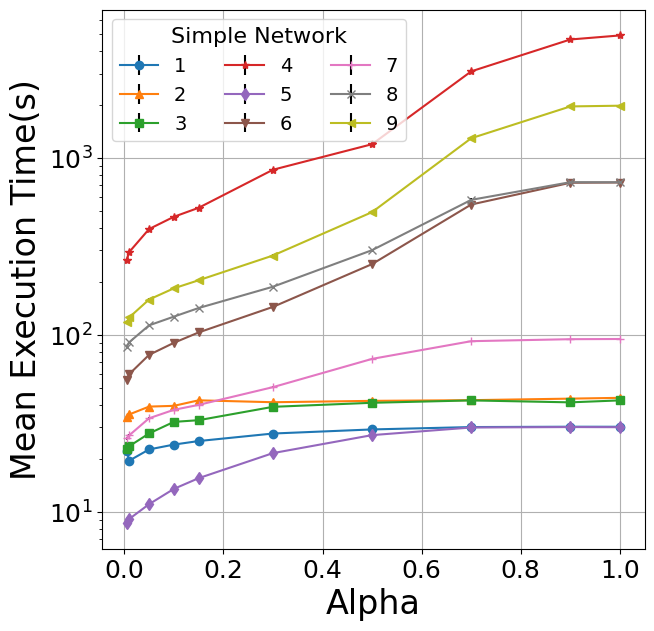

In [20]:
FASK_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
FASK_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        FASK_Mean_Exe_Time[n,a] = np.mean(np.array(fask_simple_net_execution_time[n])[:,a])
        FASK_std_Exe_Time[n,a] = np.std(np.array(fask_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, FASK_Mean_Exe_Time[n,:], FASK_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)


### FASK Performance

In [21]:
fask_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]

fask_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]


for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        for a in range(0, len(alpha)):
           
                true_graph_matrix = np.array(ground_truth_graph_matrix_all_networks[n])
                estimated_graph_matrix = np.array(fask_link_matrix_all_simple_net[n][r][a])
                
                adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(true_graph_matrix, estimated_graph_matrix)

                fask_adj_TPR_all_rep[n][r][a] = adjacency_TPR
                fask_adj_FPR_all_rep[n][r][a] = adjacency_FPR
                fask_adj_Recall_all_rep[n][r][a] = adjacency_Recall
                fask_adj_Precision_all_rep[n][r][a] = adjacency_Precision
                fask_adj_F1_score_all_rep[n][r][a] = adjacency_F1_score

                fask_ori_TPR_all_rep[n][r][a] = orientation_TPR
                fask_ori_FPR_all_rep[n][r][a] = orientation_FPR
                fask_ori_Recall_all_rep[n][r][a] = orientation_Recall
                fask_ori_Precision_all_rep[n][r][a] = orientation_Precision
                fask_ori_F1_score_all_rep[n][r][a] = orientation_F1_score


### Recall, Precision, and F1 score with Error Bars for different values of alpha

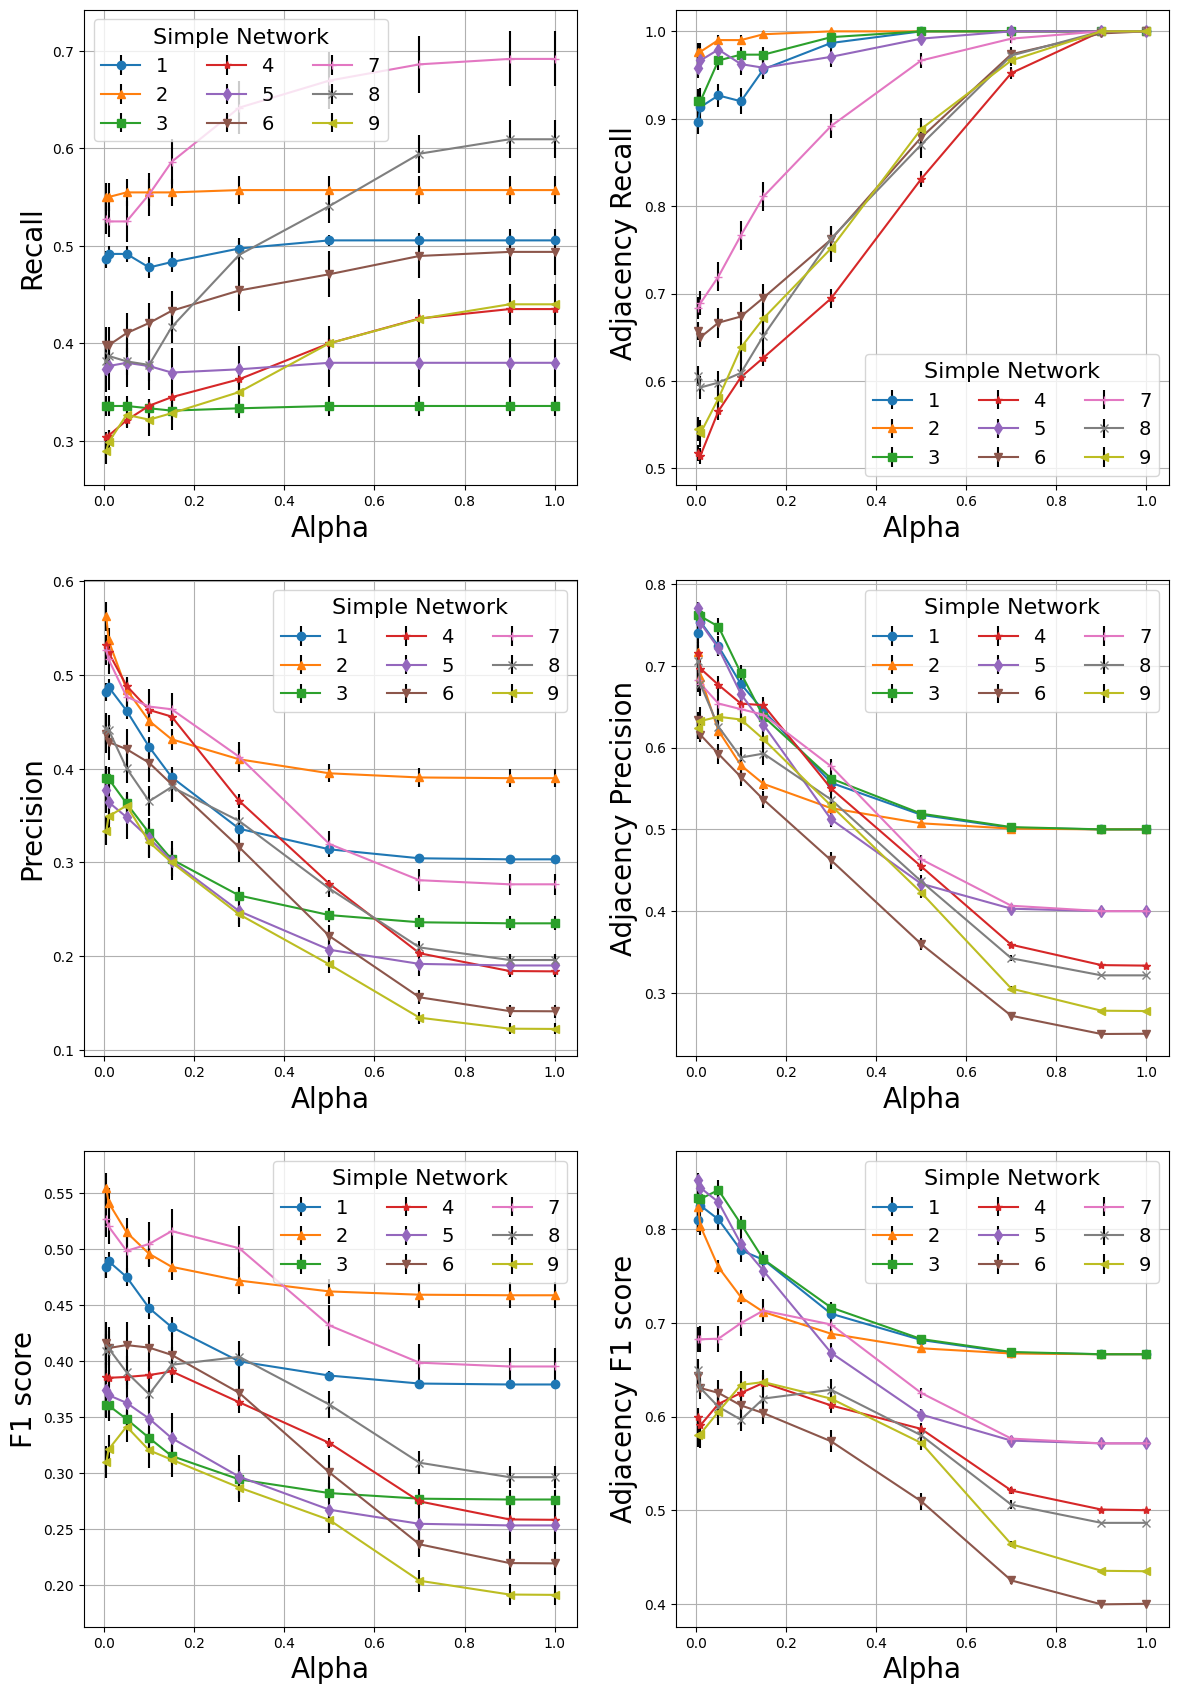

In [22]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14, 21))

fask_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
fask_best_alpha_adj_median = np.zeros((num_simple_networks,1))
fask_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
fask_best_alpha_ori_median = np.zeros((num_simple_networks,1))

for n in range(0, num_simple_networks):
    
    fask_adj_recall_mean = np.zeros_like(alpha)
    fask_adj_recall_std = np.zeros_like(alpha)
    fask_adj_recall_median = np.zeros_like(alpha)

    fask_adj_precision_mean = np.zeros_like(alpha) 
    fask_adj_precision_std = np.zeros_like(alpha)
    fask_adj_precision_median = np.zeros_like(alpha) 

    fask_adj_F1_score_mean = np.zeros_like(alpha) 
    fask_adj_F1_score_std = np.zeros_like(alpha)
    fask_adj_F1_score_median = np.zeros_like(alpha) 

    fask_ori_recall_mean = np.zeros_like(alpha)
    fask_ori_recall_std = np.zeros_like(alpha)
    fask_ori_recall_median = np.zeros_like(alpha)

    fask_ori_precision_mean = np.zeros_like(alpha)
    fask_ori_precision_std = np.zeros_like(alpha)
    fask_ori_precision_median = np.zeros_like(alpha)

    fask_ori_F1_score_mean = np.zeros_like(alpha)
    fask_ori_F1_score_std = np.zeros_like(alpha)
    fask_ori_F1_score_median = np.zeros_like(alpha)

    for a in range(0,len(alpha)):

        fask_adj_recall_mean[a] = np.mean(np.array(fask_adj_Recall_all_rep[n])[:,a])
        fask_adj_recall_std[a] = np.std(np.array(fask_adj_Recall_all_rep[n])[:,a])
        fask_adj_recall_median[a] = np.median(np.array(fask_adj_Recall_all_rep[n])[:,a])

        fask_adj_precision_mean[a] = np.mean(np.array(fask_adj_Precision_all_rep[n])[:,a])
        fask_adj_precision_std[a] = np.std(np.array(fask_adj_Precision_all_rep[n])[:,a])
        fask_adj_precision_median[a] = np.median(np.array(fask_adj_Precision_all_rep[n])[:,a])

        fask_adj_F1_score_mean[a] = np.mean(np.array(fask_adj_F1_score_all_rep[n])[:,a])
        fask_adj_F1_score_std[a] = np.std(np.array(fask_adj_F1_score_all_rep[n])[:,a])
        fask_adj_F1_score_median[a] = np.median(np.array(fask_adj_F1_score_all_rep[n])[:,a])

        fask_ori_recall_mean[a] = np.mean(np.array(fask_ori_Recall_all_rep[n])[:,a])
        fask_ori_recall_std[a] = np.std(np.array(fask_ori_Recall_all_rep[n])[:,a])
        fask_ori_recall_median[a] = np.median(np.array(fask_ori_Recall_all_rep[n])[:,a])

        fask_ori_precision_mean[a] = np.mean(np.array(fask_ori_Precision_all_rep[n])[:,a])
        fask_ori_precision_std[a] = np.std(np.array(fask_ori_Precision_all_rep[n])[:,a])
        fask_ori_precision_median[a] = np.median(np.array(fask_ori_Precision_all_rep[n])[:,a])

        fask_ori_F1_score_mean[a] = np.mean(np.array(fask_ori_F1_score_all_rep[n])[:,a])
        fask_ori_F1_score_std[a] = np.std(np.array(fask_ori_F1_score_all_rep[n])[:,a])
        fask_ori_F1_score_median[a] = np.median(np.array(fask_ori_F1_score_all_rep[n])[:,a])

    fask_best_alpha_adj_mean[n] = alpha[np.argmax(fask_adj_F1_score_mean)]
    fask_best_alpha_adj_median[n] = alpha[np.argmax(fask_adj_F1_score_median)]
    fask_best_alpha_ori_mean[n] = alpha[np.argmax(fask_ori_F1_score_mean)]
    fask_best_alpha_ori_median[n] = alpha[np.argmax(fask_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha, fask_adj_recall_mean, fask_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel(' Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, fask_ori_recall_mean, fask_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha, fask_adj_precision_mean, fask_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha, fask_ori_precision_mean, fask_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha, fask_adj_F1_score_mean, fask_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha, fask_ori_F1_score_mean, fask_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## PCMCI

In [23]:
# pcmci_link_matrix_all_simple_net = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
# pcmci_pval_matrix_all_simple_net = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
# pcmci_simple_net_execution_time = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

# for n in range(0, num_simple_networks):

#        current_simple_net = simple_net_all_data[n]
#        nodes_simple_net = all_net_nodes_dict[str(n+1)]

#        for r in range(0,num_rep_simple_net):
              
#               dataframe  = pp.DataFrame(current_simple_net[r].to_numpy(), var_names = nodes_simple_net)
#               pcmci = PCMCI(dataframe = dataframe, cond_ind_test = parcorr)

#               for a in range(0, len(alpha_level_pcmci)):

#                      start = time.time()
#                      link_matrix = pcmci.run_pcmci(tau_min = tau_min, tau_max = tau_max, pc_alpha = pc_alpha, alpha_level = alpha_level_pcmci[a])
                     
#                      end = time.time()
#                      print('network %d'% (n+1), 'repetition %d'%(r+1), 'alpha level = %0.3f'%alpha_level_pcmci[a], 'execution time: %0.3f s'%(end-start) )
                     
#                      pcmci_simple_net_execution_time[n][r][a] = end-start
#                      pcmci_link_matrix_all_simple_net[n][r][a] = link_matrix['graph']
#                      pcmci_pval_matrix_all_simple_net[n][r][a] = link_matrix['p_matrix']

### Plot execution time for PCMCI for different networks and different values of alpha

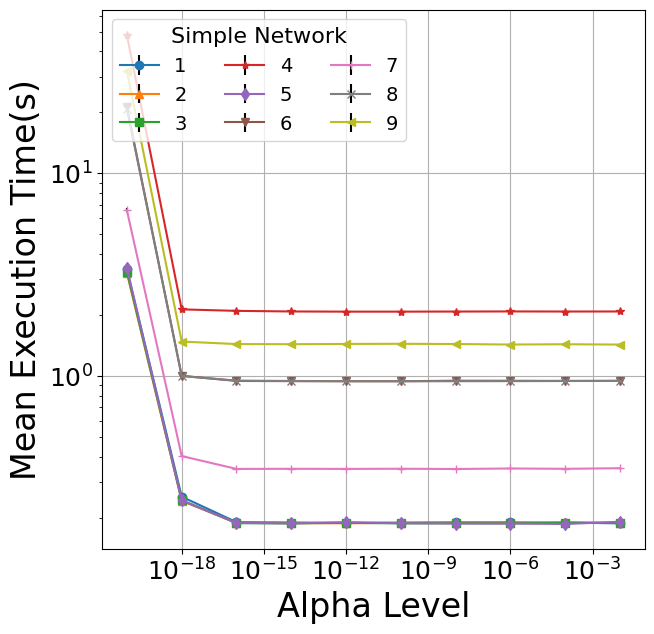

In [24]:
PCMCI_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha_level_pcmci)))
PCMCI_std_Exe_Time = np.zeros((num_simple_networks, len(alpha_level_pcmci)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha_level_pcmci)):
        PCMCI_Mean_Exe_Time[n,a] = np.mean(np.array(pcmci_simple_net_execution_time[n])[:,a])
        PCMCI_std_Exe_Time[n,a] = np.std(np.array(pcmci_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha_level_pcmci, PCMCI_Mean_Exe_Time[n,:], PCMCI_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)

#### PCMCI Performance

In [25]:
pcmci_adj_TPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_FPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_Recall_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_Precision_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

pcmci_ori_TPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_FPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_Recall_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_Precision_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha_level_pcmci)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            PAG = np.array(pcmci_link_matrix_all_simple_net[n][r][a])
            estimated_non_zero_lags_combined = find_binary_matrix_lag_non_zero_combined(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(ground_truth, estimated_non_zero_lags_combined)

            pcmci_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            pcmci_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            pcmci_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            pcmci_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            pcmci_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            pcmci_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            pcmci_ori_FPR_all_rep [n][r][a] = orientation_FPR
            pcmci_ori_Recall_all_rep[n][r][a] = orientation_Recall
            pcmci_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            pcmci_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

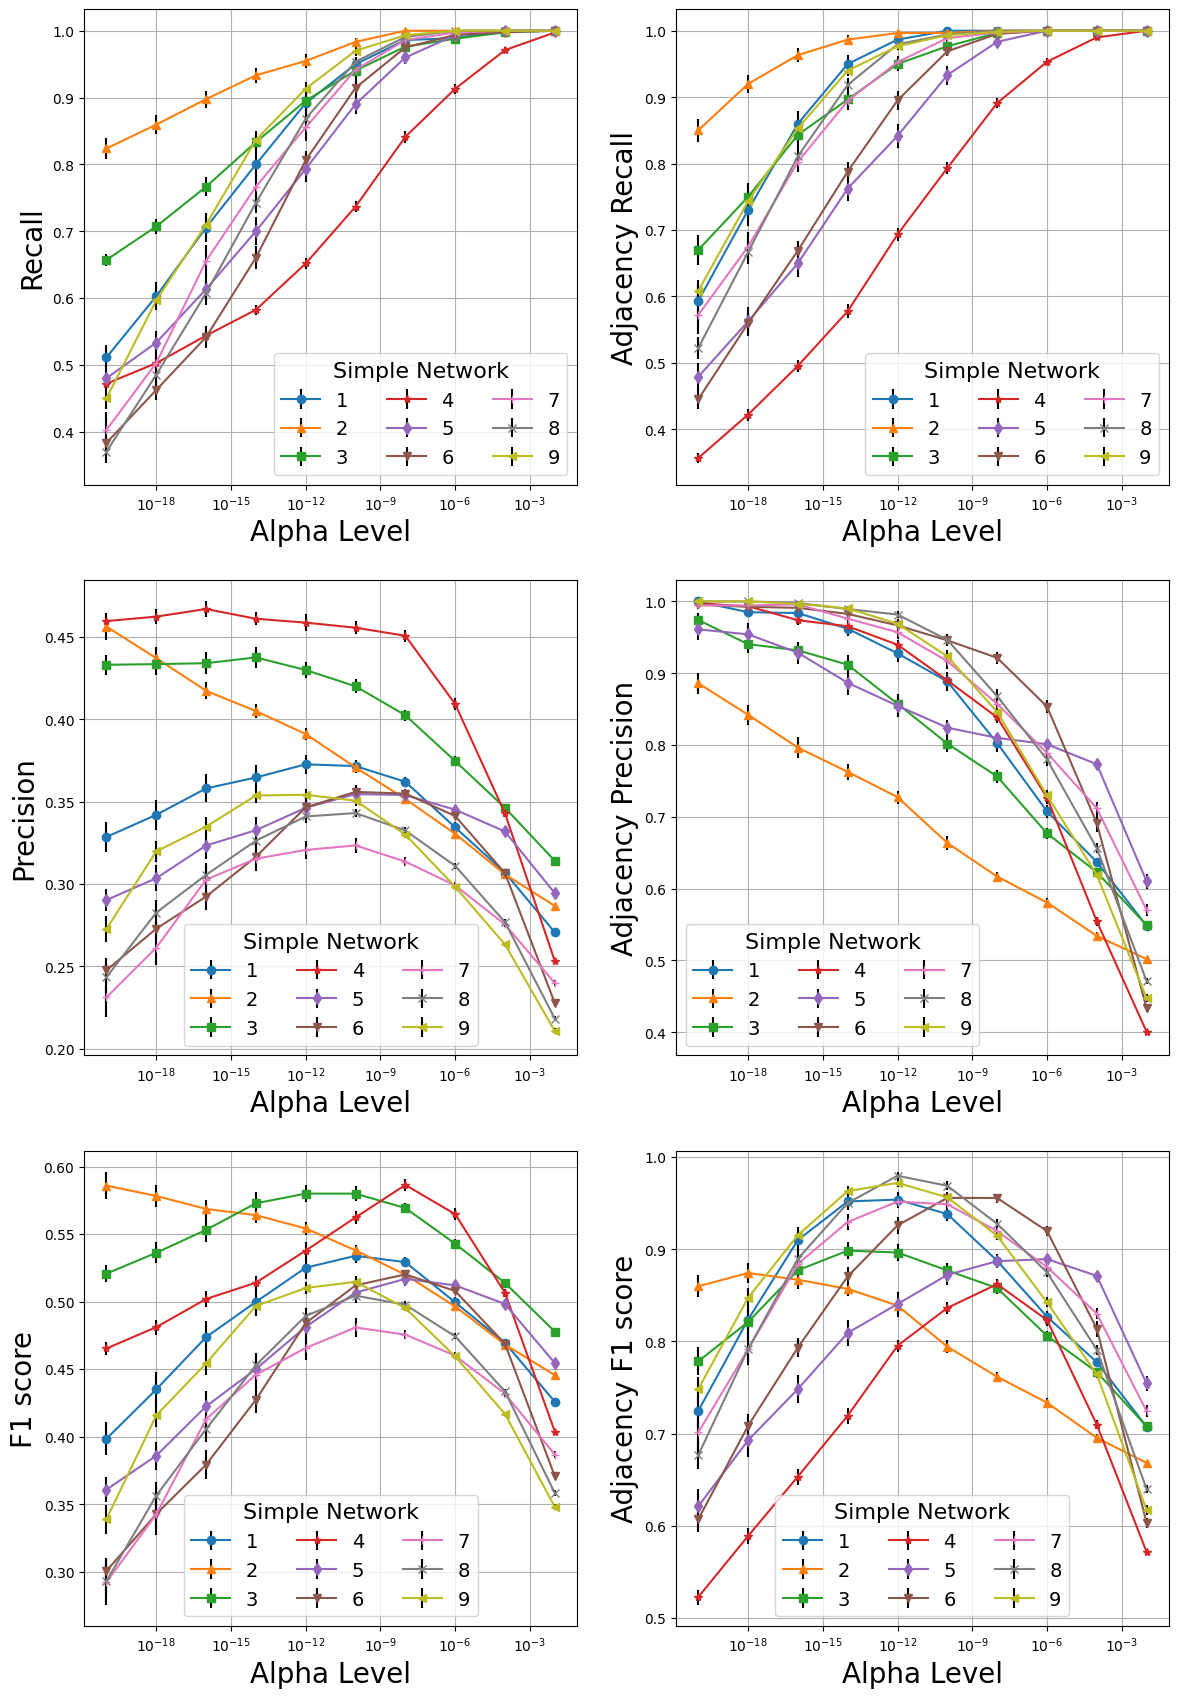

In [26]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
pcmci_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
pcmci_best_alpha_adj_median = np.zeros((num_simple_networks,1))
pcmci_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
pcmci_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):

    pcmci_adj_recall_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_median = np.zeros_like(alpha_level_pcmci)


    pcmci_adj_precision_mean = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_precision_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_precision_median = np.zeros_like(alpha_level_pcmci) 


    pcmci_adj_F1_score_mean = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_F1_score_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_F1_score_median = np.zeros_like(alpha_level_pcmci) 


    pcmci_ori_recall_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_std = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_median = np.zeros_like(alpha_level_pcmci)


    pcmci_ori_precision_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_std = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_median = np.zeros_like(alpha_level_pcmci)


    pcmci_ori_F1_score_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_std =np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_median = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        pcmci_adj_recall_mean[a] = np.mean(np.array(pcmci_adj_Recall_all_rep[n])[:,a])
        pcmci_adj_recall_std[a] = np.std(np.array(pcmci_adj_Recall_all_rep[n])[:,a])
        pcmci_adj_recall_median[a] = np.median(np.array(pcmci_adj_Recall_all_rep[n])[:,a])


        pcmci_adj_precision_mean[a] = np.mean(np.array(pcmci_adj_Precision_all_rep[n])[:,a])
        pcmci_adj_precision_std[a] = np.std(np.array(pcmci_adj_Precision_all_rep[n])[:,a])
        pcmci_adj_precision_median[a] = np.median(np.array(pcmci_adj_Precision_all_rep[n])[:,a])


        pcmci_adj_F1_score_mean[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])
        pcmci_adj_F1_score_std[a] = np.std(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])
        pcmci_adj_F1_score_median[a] = np.median(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])


        pcmci_ori_recall_mean[a] = np.mean(np.array(pcmci_ori_Recall_all_rep[n])[:,a])
        pcmci_ori_recall_std[a] = np.std(np.array(pcmci_ori_Recall_all_rep[n])[:,a])
        pcmci_ori_recall_median[a] = np.median(np.array(pcmci_ori_Recall_all_rep[n])[:,a])


        pcmci_ori_precision_mean[a] = np.mean(np.array(pcmci_ori_Precision_all_rep[n])[:,a])
        pcmci_ori_precision_std[a] = np.std(np.array(pcmci_ori_Precision_all_rep[n])[:,a])
        pcmci_ori_precision_median[a] = np.median(np.array(pcmci_ori_Precision_all_rep[n])[:,a])


        pcmci_ori_F1_score_mean[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])
        pcmci_ori_F1_score_std[a] = np.std(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])
        pcmci_ori_F1_score_median[a] = np.median(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])

    pcmci_best_alpha_adj_mean[n] = alpha_level_pcmci[np.argmax(pcmci_adj_F1_score_mean)]
    pcmci_best_alpha_adj_median[n] = alpha_level_pcmci[np.argmax(pcmci_adj_F1_score_median)]
    pcmci_best_alpha_ori_mean[n] = alpha_level_pcmci[np.argmax(pcmci_ori_F1_score_mean)]
    pcmci_best_alpha_ori_median[n] = alpha_level_pcmci[np.argmax(pcmci_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_recall_mean, pcmci_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_recall_mean, pcmci_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_precision_mean, pcmci_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_precision_mean, pcmci_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_F1_score_mean, pcmci_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_F1_score_mean, pcmci_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## PCMCIplus

### Execution Time

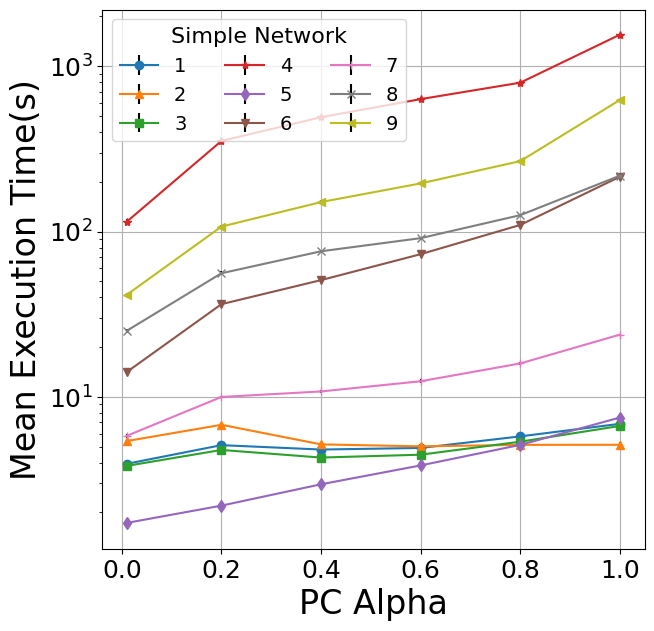

In [27]:
PCMCIplus_Mean_Exe_Time = np.zeros((num_simple_networks, len(pc_alpha_pcmciplus)))
PCMCIplus_std_Exe_Time = np.zeros((num_simple_networks, len(pc_alpha_pcmciplus)))
for n in range(0, num_simple_networks):
    for a in range(0, len(pc_alpha_pcmciplus)):
        PCMCIplus_Mean_Exe_Time[n,a] = np.mean(np.array(pcmciplus_simple_net_execution_time[n])[:,a])
        PCMCIplus_std_Exe_Time[n,a] = np.std(np.array(pcmciplus_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(pc_alpha_pcmciplus, PCMCIplus_Mean_Exe_Time[n,:], PCMCIplus_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('PC Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(visible = True)

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### PCMCIplus Performance

In [28]:
pcmciplus_adj_TPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_FPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_Recall_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_Precision_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_F1_score_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

pcmciplus_ori_TPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_FPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_Recall_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_Precision_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_F1_score_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]


estimated_time_lagged_graph = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
estimated_binary_graphs_all = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(pc_alpha_pcmciplus)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
                        
            PAG = np.array(pcmciplus_link_matrix_all_simple_net[n][r][a])

            estimated_time_lagged_graph[n][r][a] = PAG
            estimated_graph = summarize_across_all_lags(PAG)

            estimated_binary_graphs_all[n][r][a] = estimated_graph


            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(ground_truth, estimated_graph)

            pcmciplus_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            pcmciplus_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            pcmciplus_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            pcmciplus_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            pcmciplus_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            pcmciplus_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            pcmciplus_ori_FPR_all_rep [n][r][a] = orientation_FPR
            pcmciplus_ori_Recall_all_rep[n][r][a] = orientation_Recall
            pcmciplus_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            pcmciplus_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

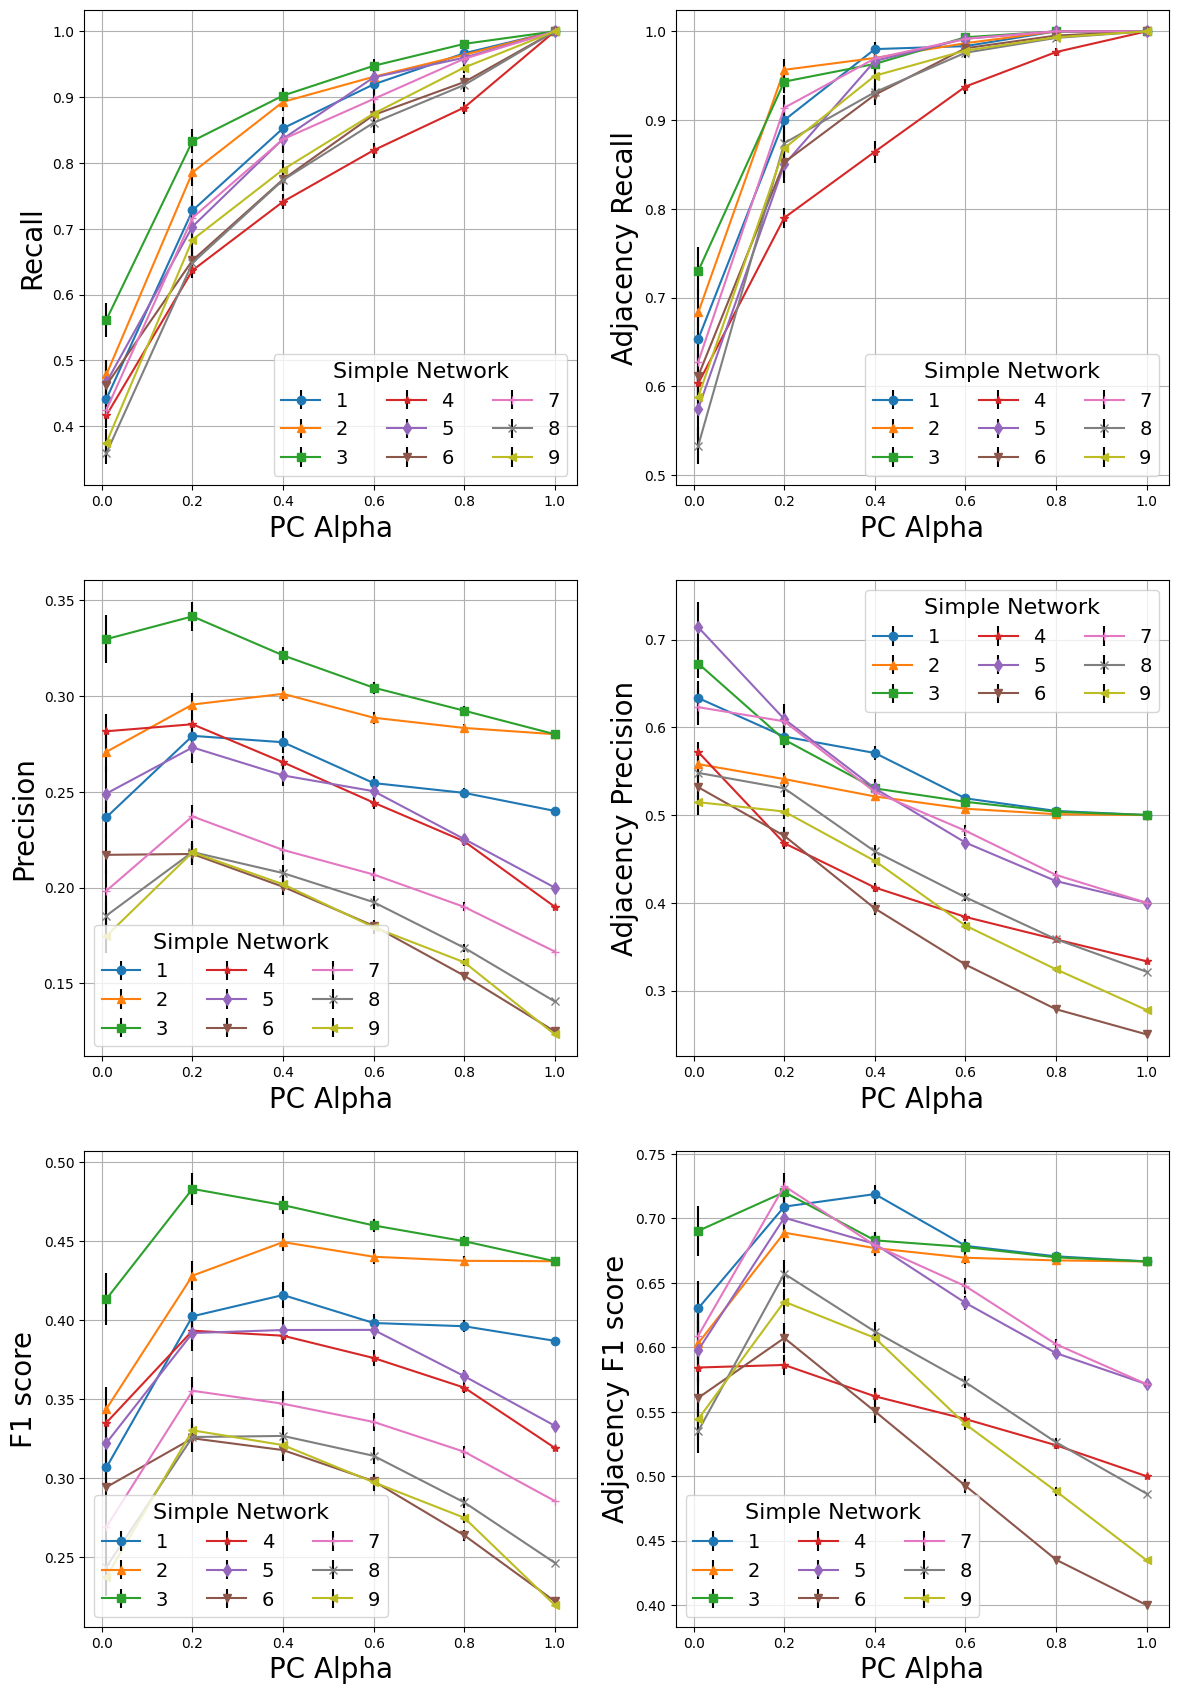

In [29]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
pcmciplus_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_adj_median = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):

    pcmciplus_adj_recall_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_recall_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_recall_median = np.zeros_like(pc_alpha_pcmciplus)

    pcmciplus_adj_precision_mean = np.zeros_like(pc_alpha_pcmciplus) 
    pcmciplus_adj_precision_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_precision_median = np.zeros_like(pc_alpha_pcmciplus) 

    pcmciplus_adj_F1_score_mean = np.zeros_like(pc_alpha_pcmciplus) 
    pcmciplus_adj_F1_score_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_F1_score_median = np.zeros_like(pc_alpha_pcmciplus) 


    pcmciplus_ori_recall_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_recall_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_recall_median = np.zeros_like(pc_alpha_pcmciplus)


    pcmciplus_ori_precision_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_precision_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_precision_median = np.zeros_like(pc_alpha_pcmciplus)


    pcmciplus_ori_F1_score_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_F1_score_std =np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_F1_score_median = np.zeros_like(pc_alpha_pcmciplus)


    for a in range(0,len(pc_alpha_pcmciplus)):

        pcmciplus_adj_recall_mean[a] = np.mean(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])
        pcmciplus_adj_recall_std[a] = np.std(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])
        pcmciplus_adj_recall_median[a] = np.median(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])

        pcmciplus_adj_precision_mean[a] = np.mean(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])
        pcmciplus_adj_precision_std[a] = np.std(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])
        pcmciplus_adj_precision_median[a] = np.median(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])

        pcmciplus_adj_F1_score_mean[a] = np.mean(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])
        pcmciplus_adj_F1_score_std[a] = np.std(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])
        pcmciplus_adj_F1_score_median[a] = np.median(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])

        pcmciplus_ori_recall_mean[a] = np.mean(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])
        pcmciplus_ori_recall_std[a] = np.std(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])
        pcmciplus_ori_recall_median[a] = np.median(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])

        pcmciplus_ori_precision_mean[a] = np.mean(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])
        pcmciplus_ori_precision_std[a] = np.std(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])
        pcmciplus_ori_precision_median[a] = np.median(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])

        pcmciplus_ori_F1_score_mean[a] = np.mean(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])
        pcmciplus_ori_F1_score_std[a] = np.std(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])
        pcmciplus_ori_F1_score_median[a] = np.median(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])

    pcmciplus_best_alpha_adj_mean[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_adj_F1_score_mean)]
    pcmciplus_best_alpha_adj_median[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_adj_F1_score_median)]
    pcmciplus_best_alpha_ori_mean[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_ori_F1_score_mean)]
    pcmciplus_best_alpha_ori_median[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_recall_mean, pcmciplus_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,1)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_recall_mean, pcmciplus_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,4)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_precision_mean, pcmciplus_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,3)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_precision_mean, pcmciplus_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,6)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_F1_score_mean, pcmciplus_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_F1_score_mean, pcmciplus_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## Dynotears

In [30]:
# dynotears_link_matrix_all_simple_net = [[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
# dynotears_simple_net_execution_time = [[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

# for n in range(0,num_simple_networks):

#        current_simple_net = simple_net_all_data[n]
#        nodes_simple_net = all_net_nodes_dict[str(n+1)]

#        for i in range(0,num_rep_simple_net):

#               dataframe  = pd.DataFrame(current_simple_net[i].to_numpy(), columns = nodes_simple_net)

#               for a in range(0,len(alpha_dynotears)):

#                      start = time.time()
#                      graph = dynotears(dataframe, tau_max=tau_max, alpha=alpha_dynotears[a])
#                      end = time.time()

#                      print('network %d'% (n+1), 'repetition %d'%(i+1), 'alpha = %0.6f'%alpha_dynotears[a], 'execution time: %0.3f s'%(end-start) )

#                      dynotears_simple_net_execution_time[n][i][a] = end-start
#                      dynotears_link_matrix_all_simple_net[n][i][a] = make_time_lag_graph_from_dict(graph,tau_max)

### Plot execution time for Dynotears for different networks and different values of alpha

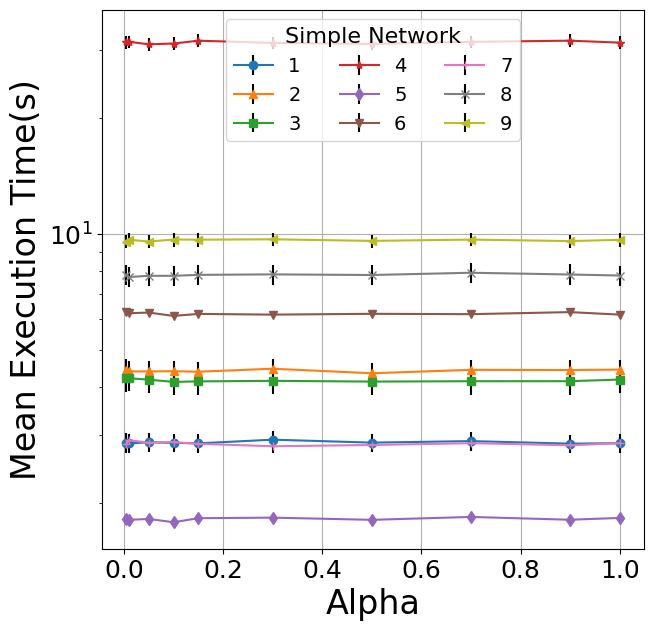

In [31]:
Dynotears_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
Dynotears_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        Dynotears_Mean_Exe_Time[n,a] = np.mean(np.array(dynotears_simple_net_execution_time[n])[:,a])
        Dynotears_std_Exe_Time[n,a] = np.std(np.array(dynotears_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, Dynotears_Mean_Exe_Time[n,:], Dynotears_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### Dynotears Performance

In [32]:
dynotears_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

dynotears_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha_dynotears)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            PAG = np.array(dynotears_link_matrix_all_simple_net[n][r][a])
            estimated_non_zero_lags_combined = find_binary_matrix_lag_non_zero_combined(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(ground_truth, estimated_non_zero_lags_combined)

            dynotears_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            dynotears_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            dynotears_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            dynotears_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            dynotears_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            dynotears_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            dynotears_ori_FPR_all_rep [n][r][a] = orientation_FPR
            dynotears_ori_Recall_all_rep[n][r][a] = orientation_Recall
            dynotears_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            dynotears_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

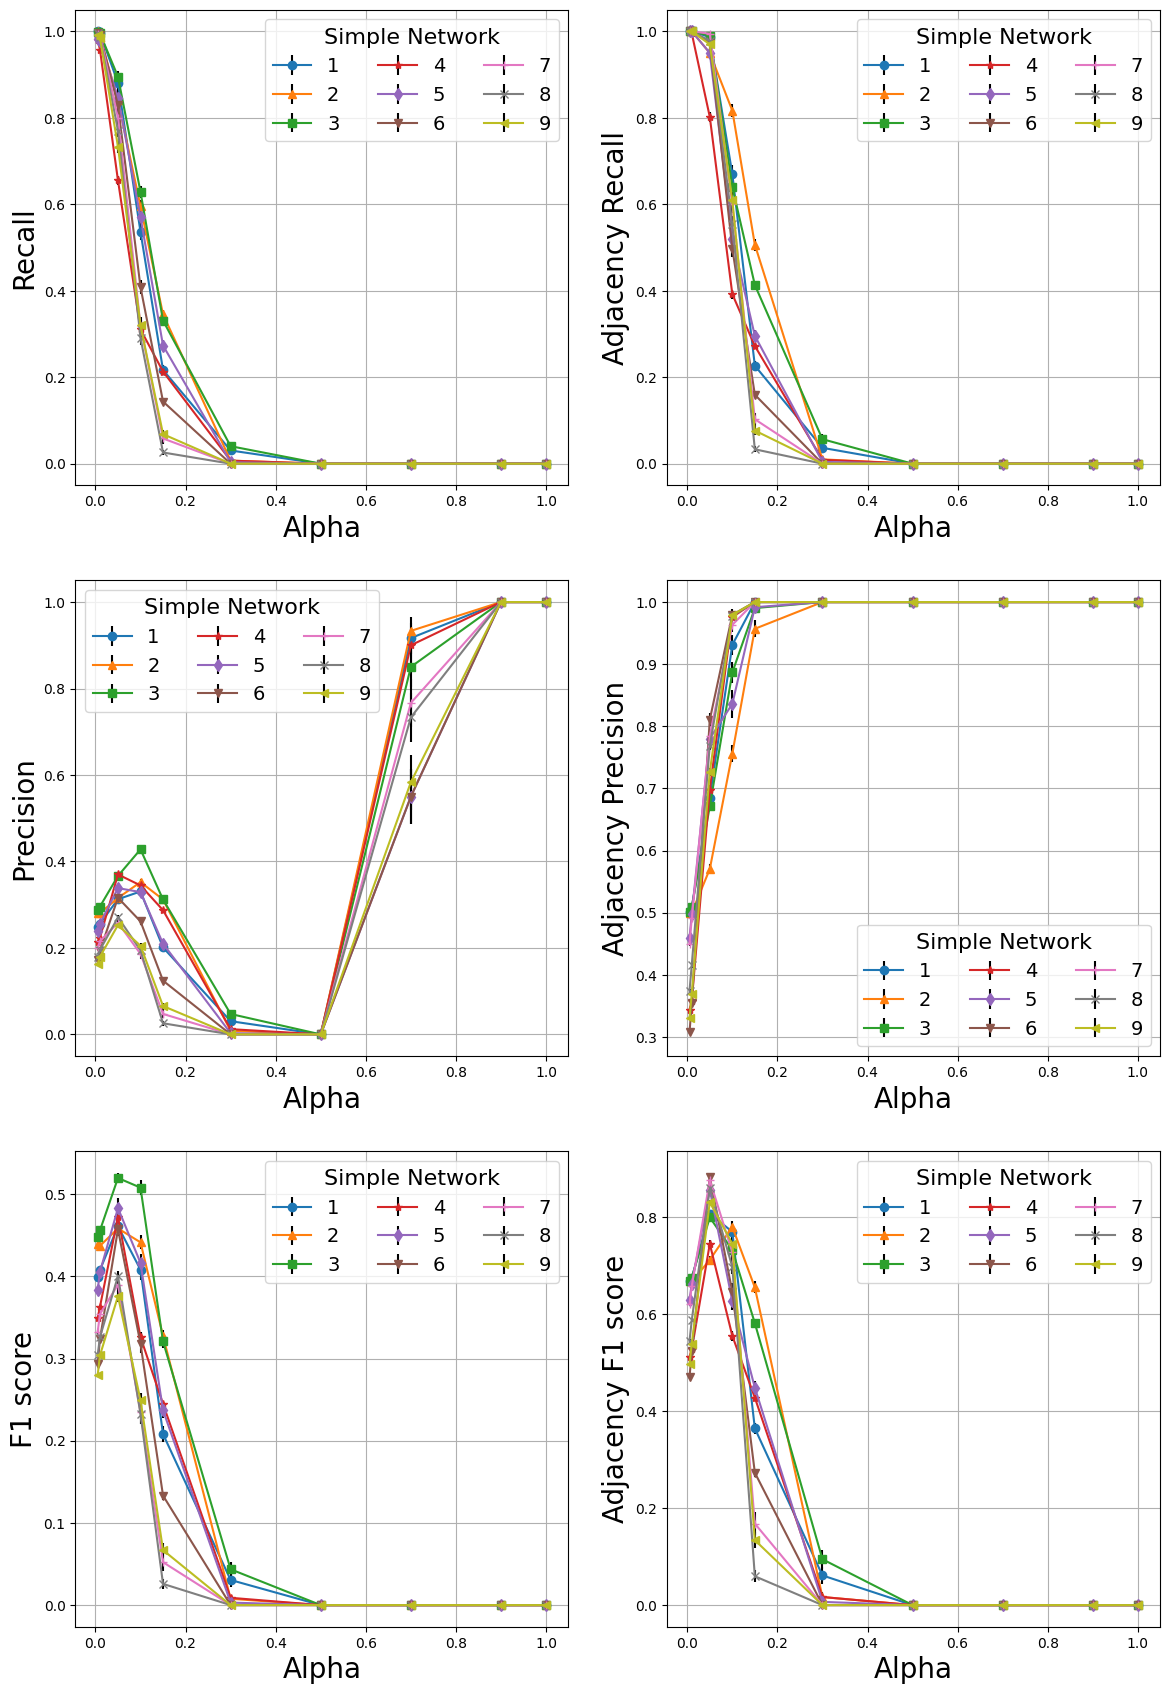

In [33]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
dynotears_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
dynotears_best_alpha_adj_median = np.zeros((num_simple_networks,1))
dynotears_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
dynotears_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0, num_simple_networks):
    dynotears_adj_recall_mean = np.zeros_like(alpha_dynotears)
    dynotears_adj_recall_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_recall_median = np.zeros_like(alpha_dynotears)


    dynotears_adj_precision_mean = np.zeros_like(alpha_dynotears) 
    dynotears_adj_precision_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_precision_median = np.zeros_like(alpha_dynotears) 


    dynotears_adj_F1_score_mean = np.zeros_like(alpha_dynotears) 
    dynotears_adj_F1_score_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_F1_score_median = np.zeros_like(alpha_dynotears) 


    dynotears_ori_recall_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_recall_std = np.zeros_like(alpha_dynotears)
    dynotears_ori_recall_median = np.zeros_like(alpha_dynotears)


    dynotears_ori_precision_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_precision_std = np.zeros_like(alpha_dynotears)
    dynotears_ori_precision_median = np.zeros_like(alpha_dynotears)


    dynotears_ori_F1_score_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_F1_score_std =np.zeros_like(alpha_dynotears)
    dynotears_ori_F1_score_median = np.zeros_like(alpha_dynotears)



    for a in range(0,len(alpha_dynotears)):

        dynotears_adj_recall_mean[a] = np.mean(np.array(dynotears_adj_Recall_all_rep[n])[:,a])
        dynotears_adj_recall_std[a] = np.std(np.array(dynotears_adj_Recall_all_rep[n])[:,a])
        dynotears_adj_recall_median[a] = np.median(np.array(dynotears_adj_Recall_all_rep[n])[:,a])


        dynotears_adj_precision_mean[a] = np.mean(np.array(dynotears_adj_Precision_all_rep[n])[:,a])
        dynotears_adj_precision_std[a] = np.std(np.array(dynotears_adj_Precision_all_rep[n])[:,a])
        dynotears_adj_precision_median[a] = np.median(np.array(dynotears_adj_Precision_all_rep[n])[:,a])



        dynotears_adj_F1_score_mean[a] = np.mean(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])
        dynotears_adj_F1_score_std[a] = np.std(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])
        dynotears_adj_F1_score_median[a] = np.median(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])


        dynotears_ori_recall_mean[a] = np.mean(np.array(dynotears_ori_Recall_all_rep[n])[:,a])
        dynotears_ori_recall_std[a] = np.std(np.array(dynotears_ori_Recall_all_rep[n])[:,a])
        dynotears_ori_recall_median[a] = np.median(np.array(dynotears_ori_Recall_all_rep[n])[:,a])


        dynotears_ori_precision_mean[a] = np.mean(np.array(dynotears_ori_Precision_all_rep[n])[:,a])
        dynotears_ori_precision_std[a] = np.std(np.array(dynotears_ori_Precision_all_rep[n])[:,a])
        dynotears_ori_precision_median[a] = np.median(np.array(dynotears_ori_Precision_all_rep[n])[:,a])


        dynotears_ori_F1_score_mean[a] = np.mean(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])
        dynotears_ori_F1_score_std[a] = np.std(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])
        dynotears_ori_F1_score_median[a] = np.median(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])

    dynotears_best_alpha_adj_mean[n] = alpha_dynotears[np.argmax(dynotears_adj_F1_score_mean)]
    dynotears_best_alpha_adj_median[n] = alpha_dynotears[np.argmax(dynotears_adj_F1_score_median)]
    dynotears_best_alpha_ori_mean[n] = alpha_dynotears[np.argmax(dynotears_ori_F1_score_mean)]
    dynotears_best_alpha_ori_median[n] = alpha_dynotears[np.argmax(dynotears_ori_F1_score_median)]

    
    plt.subplot(3,2,2)
    plt.errorbar(alpha, dynotears_adj_recall_mean, dynotears_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, dynotears_ori_recall_mean, dynotears_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha, dynotears_adj_precision_mean, dynotears_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha, dynotears_ori_precision_mean, dynotears_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha, dynotears_adj_F1_score_mean, dynotears_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha, dynotears_ori_F1_score_mean, dynotears_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## VARLINGAM

In [34]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# varlingam_link_matrix_all_simple_net = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
# varlingam_simple_net_execution_time = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

# for n in range(0,num_simple_networks):
       
#        current_simple_net = simple_net_all_data[n]
#        nodes_simple_net = all_net_nodes_dict[str(n+1)]

#        for i in range(0,num_rep_simple_net):

#               dataframe  = pd.DataFrame(current_simple_net[i].to_numpy(), columns = nodes_simple_net)

#               for a in range(0,len(alpha)):

#                      start = time.time()
#                      res = varlingam(dataframe, tau_max = tau_max, alpha = alpha[a])
#                      end = time.time()
#                      print('network %d'% (n+1), 'repetition %d'%(i+1), 'alpha = %0.3f'%alpha[a], 'execution time: %0.3f s'%(end-start) )

#                      varlingam_simple_net_execution_time[n][i][a] = end-start
#                      varlingam_link_matrix_all_simple_net[n][i][a] = make_time_lag_graph_from_dict(res,tau_max)


### Plot execution time for Varlingam for different networks and different values of alpha

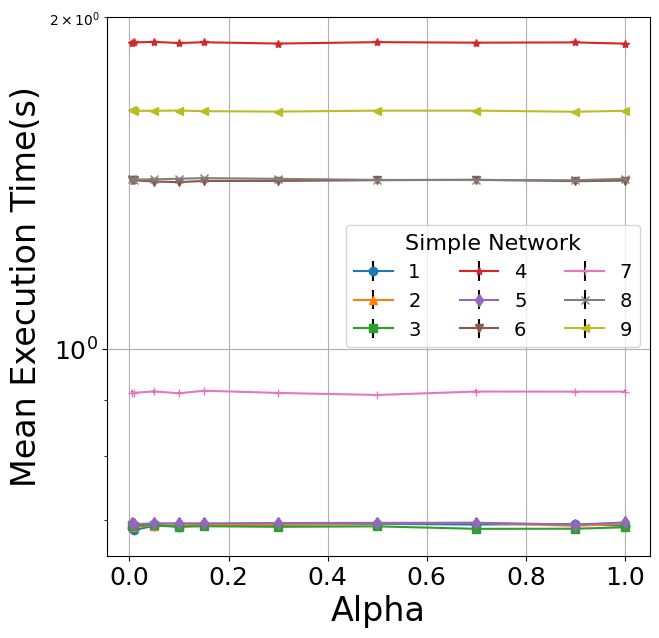

In [35]:
Varlingam_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
Varlingam_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        Varlingam_Mean_Exe_Time[n,a] = np.mean(np.array(varlingam_simple_net_execution_time[n])[:,a])
        Varlingam_std_Exe_Time[n,a] = np.std(np.array(varlingam_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, Varlingam_Mean_Exe_Time[n,:], Varlingam_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### VARLINGAM Performance

In [36]:
varlingam_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

varlingam_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]

            PAG = np.array(varlingam_link_matrix_all_simple_net[n][r][a])
            estimated_non_zero_lags_combined = find_binary_matrix_lag_non_zero_combined(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(ground_truth, estimated_non_zero_lags_combined)

            varlingam_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            varlingam_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            varlingam_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            varlingam_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            varlingam_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            varlingam_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            varlingam_ori_FPR_all_rep [n][r][a] = orientation_FPR
            varlingam_ori_Recall_all_rep[n][r][a] = orientation_Recall
            varlingam_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            varlingam_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

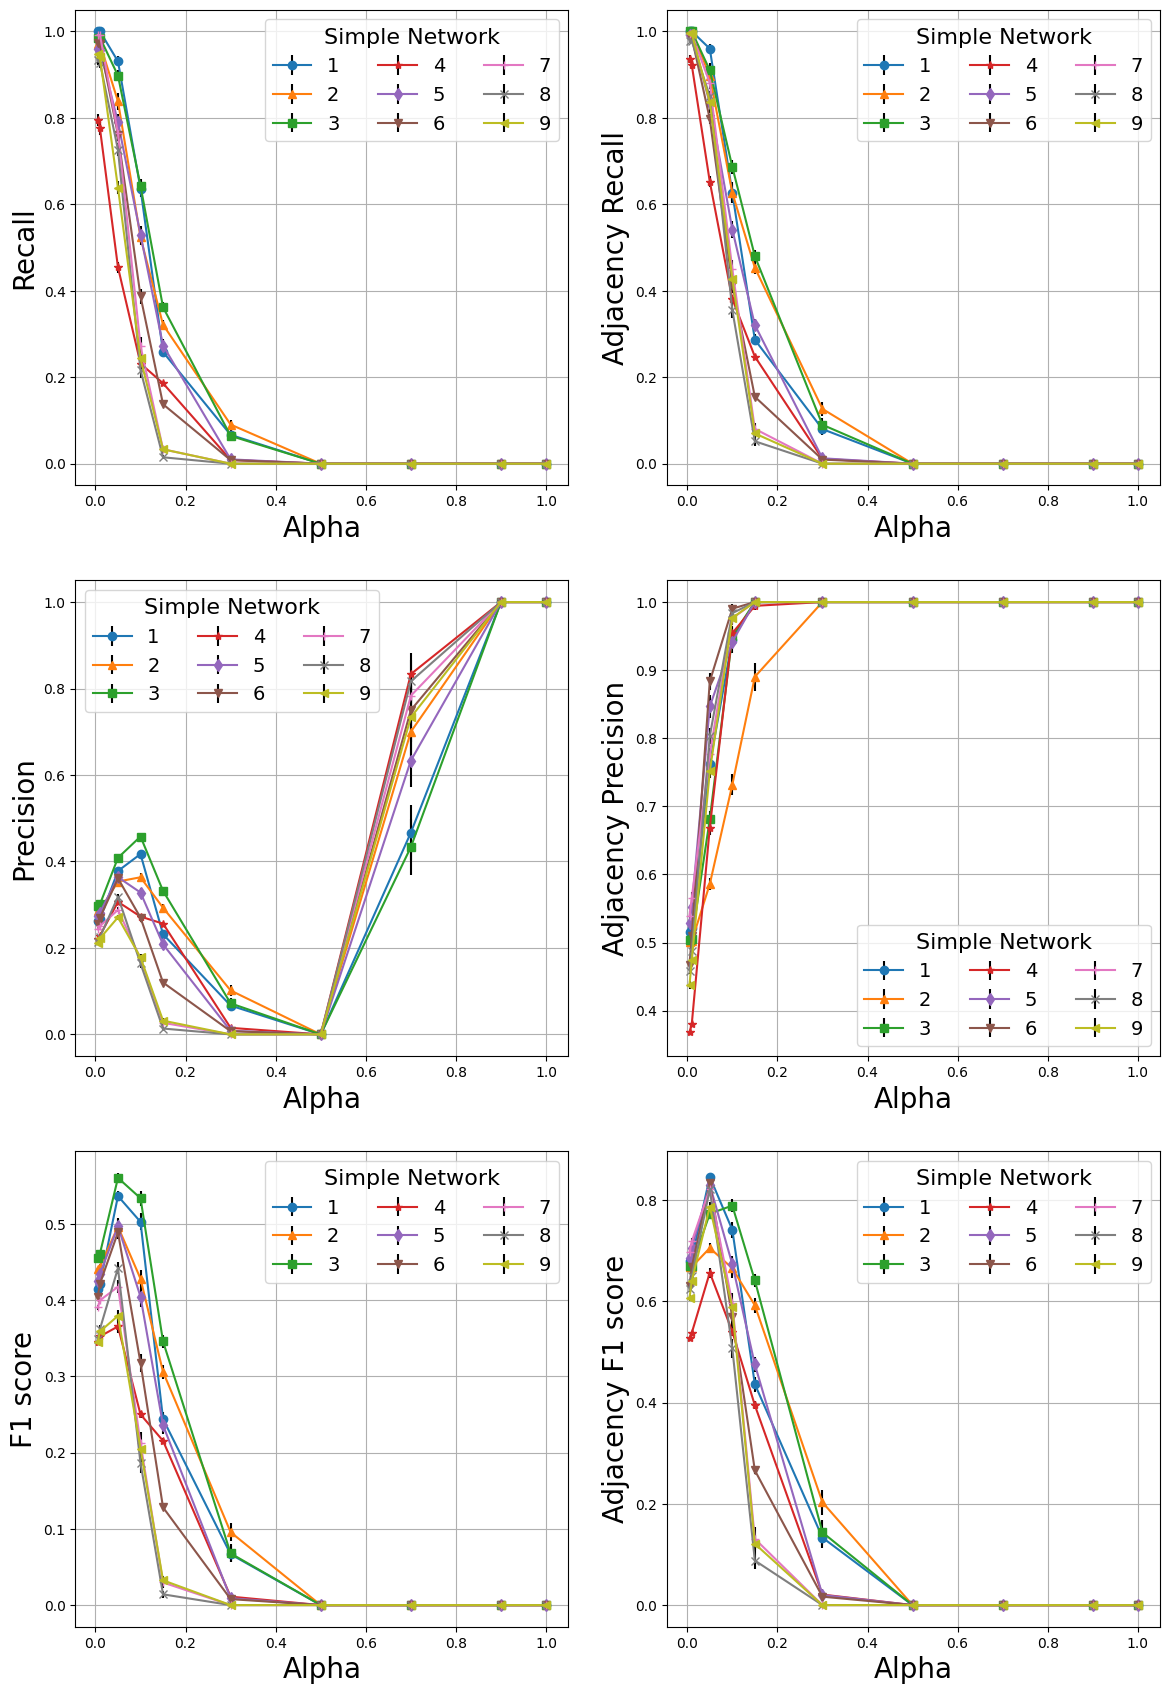

In [37]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
varlingam_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
varlingam_best_alpha_adj_median = np.zeros((num_simple_networks,1))
varlingam_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
varlingam_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):
    varlingam_adj_recall_mean = np.zeros_like(alpha)
    varlingam_adj_recall_std = np.zeros_like(alpha)
    varlingam_adj_recall_median = np.zeros_like(alpha)

    varlingam_adj_precision_mean = np.zeros_like(alpha) 
    varlingam_adj_precision_std = np.zeros_like(alpha)
    varlingam_adj_precision_median = np.zeros_like(alpha) 

    varlingam_adj_F1_score_mean = np.zeros_like(alpha) 
    varlingam_adj_F1_score_std = np.zeros_like(alpha)
    varlingam_adj_F1_score_median = np.zeros_like(alpha) 

    varlingam_ori_recall_mean = np.zeros_like(alpha)
    varlingam_ori_recall_std = np.zeros_like(alpha)
    varlingam_ori_recall_median = np.zeros_like(alpha)

    varlingam_ori_precision_mean = np.zeros_like(alpha)
    varlingam_ori_precision_std = np.zeros_like(alpha)
    varlingam_ori_precision_median = np.zeros_like(alpha)

    varlingam_ori_F1_score_mean = np.zeros_like(alpha)
    varlingam_ori_F1_score_std =np.zeros_like(alpha)
    varlingam_ori_F1_score_median = np.zeros_like(alpha)

    for a in range(0,len(alpha)):

        varlingam_adj_recall_mean[a] = np.mean(np.array(varlingam_adj_Recall_all_rep[n])[:,a])
        varlingam_adj_recall_std[a] = np.std(np.array(varlingam_adj_Recall_all_rep[n])[:,a])
        varlingam_adj_recall_median[a] = np.median(np.array(varlingam_adj_Recall_all_rep[n])[:,a])

        varlingam_adj_precision_mean[a] = np.mean(np.array(varlingam_adj_Precision_all_rep[n])[:,a])
        varlingam_adj_precision_std[a] = np.std(np.array(varlingam_adj_Precision_all_rep[n])[:,a])
        varlingam_adj_precision_median[a] = np.median(np.array(varlingam_adj_Precision_all_rep[n])[:,a])

        varlingam_adj_F1_score_mean[a] = np.mean(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])
        varlingam_adj_F1_score_std[a] = np.std(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])
        varlingam_adj_F1_score_median[a] = np.median(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])

        varlingam_ori_recall_mean[a] = np.mean(np.array(varlingam_ori_Recall_all_rep[n])[:,a])
        varlingam_ori_recall_std[a] = np.std(np.array(varlingam_ori_Recall_all_rep[n])[:,a])
        varlingam_ori_recall_median[a] = np.median(np.array(varlingam_ori_Recall_all_rep[n])[:,a])

        varlingam_ori_precision_mean[a] = np.mean(np.array(varlingam_ori_Precision_all_rep[n])[:,a])
        varlingam_ori_precision_std[a] = np.std(np.array(varlingam_ori_Precision_all_rep[n])[:,a])
        varlingam_ori_precision_median[a] = np.median(np.array(varlingam_ori_Precision_all_rep[n])[:,a])

        varlingam_ori_F1_score_mean[a] = np.mean(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])
        varlingam_ori_F1_score_std[a] = np.std(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])
        varlingam_ori_F1_score_median[a] = np.median(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])

    varlingam_best_alpha_adj_mean[n] = alpha[np.argmax(varlingam_adj_F1_score_mean)]
    varlingam_best_alpha_adj_median[n] = alpha[np.argmax(varlingam_adj_F1_score_median)]
    varlingam_best_alpha_ori_mean[n] = alpha[np.argmax(varlingam_ori_F1_score_mean)]
    varlingam_best_alpha_ori_median[n] = alpha[np.argmax(varlingam_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha, varlingam_adj_recall_mean, varlingam_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, varlingam_ori_recall_mean, varlingam_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,4)
    plt.errorbar(alpha, varlingam_adj_precision_mean, varlingam_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,3)
    plt.errorbar(alpha, varlingam_ori_precision_mean, varlingam_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,6)
    plt.errorbar(alpha, varlingam_adj_F1_score_mean, varlingam_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(alpha, varlingam_ori_F1_score_mean, varlingam_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## DGLearn

In [38]:
# dglearn_link_matrix_all_simple_net = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
# dglearn_simple_net_execution_time = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

# # learn structure using tabu search, plot learned structure
# tabu_length = 4
# patience = 4

# for n in range(0, num_simple_networks):

#        current_simple_net = simple_net_all_data[n]
#        nodes_simple_net = all_net_nodes_dict[str(n+1)]
#        var_names = nodes_simple_net 
#        n_vars = len(var_names)

#        for r in range(0,num_rep_simple_net):

#               X  = current_simple_net[r].to_numpy()
       
#               for b in range(0, len(bic_coef_all)):
#                      start = time.time()

#                      manager = dg.CyclicManager(X, bic_coef = bic_coef_all[b])
#                      learned_support, best_score, log = dg.tabu_search(manager, tabu_length, patience, first_ascent = False, verbose = 0)

#                      # perform virtual edge correction
#                      learned_support = dg.virtual_refine(manager, learned_support, patience = 0, max_path_len = 6, verbose = 0)

#                      # remove any reducible edges
#                      learned_support = dg.reduce_support(learned_support, fill_diagonal = False)

#                      end = time.time()
#                      print('network %d'% (n+1), 'repetition %d'%(r+1), 'bic_coef: %0.3f'%bic_coef_all[b], 'execution time: %0.3f s'%(end-start) )
                     
#                      dglearn_simple_net_execution_time[n][r][b] = end-start
#                      dglearn_link_matrix_all_simple_net[n][r][b] = learned_support


### Plot execution time for DGlearn for different networks and different values of alpha

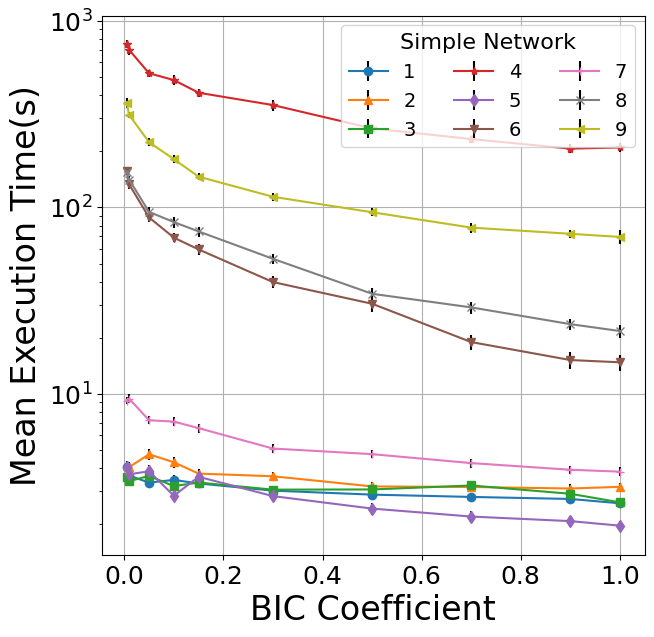

In [39]:
Dglearn_Mean_Exe_Time = np.zeros((num_simple_networks, len(bic_coef_all)))
Dglearn_std_Exe_Time = np.zeros((num_simple_networks, len(bic_coef_all)))
for n in range(0, num_simple_networks):
    for b in range(0, len(bic_coef_all)):
        Dglearn_Mean_Exe_Time[n,b] = np.mean(np.array(dglearn_simple_net_execution_time[n])[:,b])
        Dglearn_std_Exe_Time[n,b] = np.std(np.array(dglearn_simple_net_execution_time[n])[:,b])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(bic_coef_all, Dglearn_Mean_Exe_Time[n,:], Dglearn_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.xlabel('BIC Coefficient', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.yscale('log')
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### DGLearn Performance

In [40]:
dglearn_adj_TPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_FPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_Recall_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_Precision_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_F1_score_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

dglearn_ori_TPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_FPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_Recall_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_Precision_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_F1_score_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for b in range(0, len(bic_coef_all)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            graph = np.array(dglearn_link_matrix_all_simple_net[n][r][b])

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(ground_truth, graph)

            dglearn_adj_TPR_all_rep[n][r][b] = adjacency_TPR
            dglearn_adj_FPR_all_rep[n][r][b]  = adjacency_FPR
            dglearn_adj_Recall_all_rep[n][r][b]  = adjacency_Recall
            dglearn_adj_Precision_all_rep[n][r][b] = adjacency_Precision
            dglearn_adj_F1_score_all_rep[n][r][b]  = adjacency_F1_score

            dglearn_ori_TPR_all_rep[n][r][b]  = orientation_TPR
            dglearn_ori_FPR_all_rep [n][r][b] = orientation_FPR
            dglearn_ori_Recall_all_rep[n][r][b] = orientation_Recall
            dglearn_ori_Precision_all_rep[n][r][b]  = orientation_Precision
            dglearn_ori_F1_score_all_rep[n][r][b]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of BIC coeffiecient

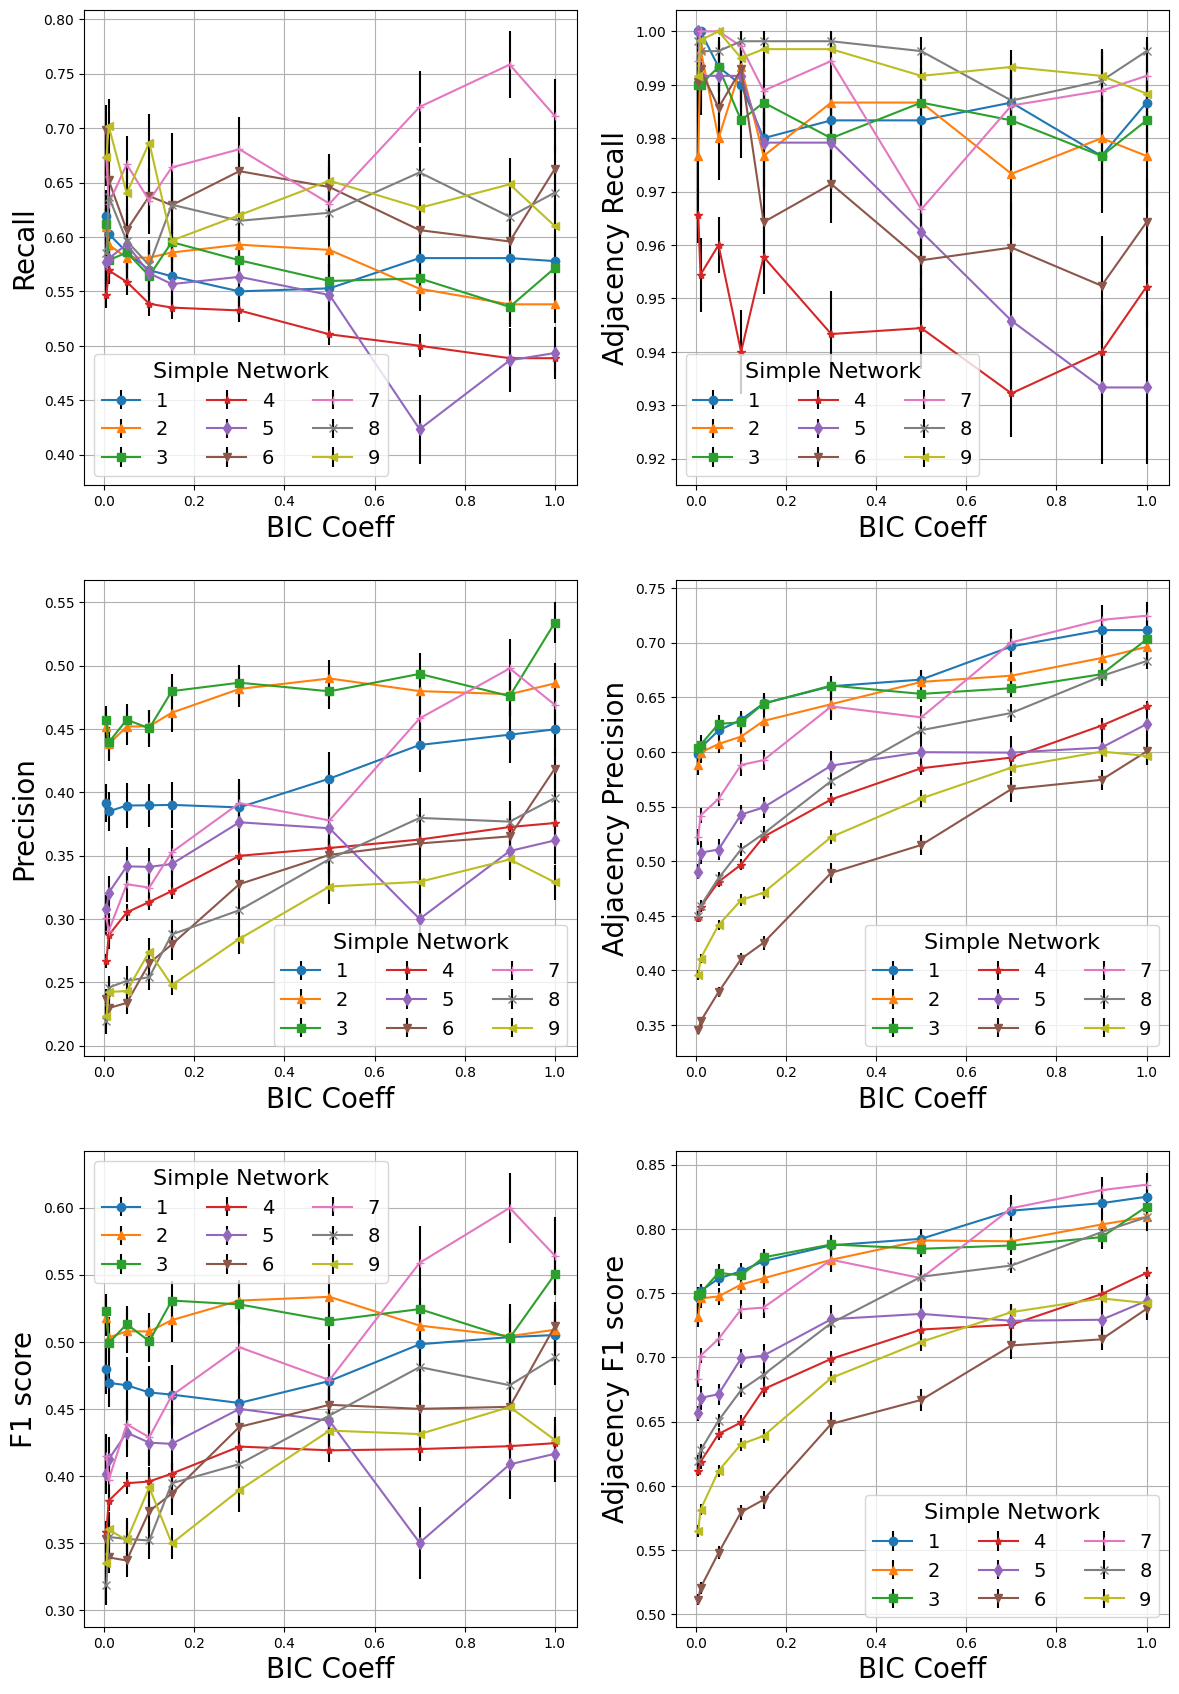

In [41]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
dglearn_best_bic_score_adj_mean = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_adj_median = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_ori_mean = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):
    dglearn_adj_recall_mean = np.zeros_like(bic_coef_all)
    dglearn_adj_recall_std = np.zeros_like(bic_coef_all)
    dglearn_adj_recall_median = np.zeros_like(bic_coef_all)


    dglearn_adj_precision_mean = np.zeros_like(bic_coef_all) 
    dglearn_adj_precision_std = np.zeros_like(bic_coef_all)
    dglearn_adj_precision_median = np.zeros_like(bic_coef_all) 


    dglearn_adj_F1_score_mean = np.zeros_like(bic_coef_all) 
    dglearn_adj_F1_score_std = np.zeros_like(bic_coef_all)
    dglearn_adj_F1_score_median = np.zeros_like(bic_coef_all) 


    dglearn_ori_recall_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_recall_std = np.zeros_like(bic_coef_all)
    dglearn_ori_recall_median = np.zeros_like(bic_coef_all)


    dglearn_ori_precision_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_precision_std = np.zeros_like(bic_coef_all)
    dglearn_ori_precision_median = np.zeros_like(bic_coef_all)


    dglearn_ori_F1_score_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_F1_score_std =np.zeros_like(bic_coef_all)
    dglearn_ori_F1_score_median = np.zeros_like(bic_coef_all)



    for b in range(0,len(bic_coef_all)):

        dglearn_adj_recall_mean[b] = np.mean(np.array(dglearn_adj_Recall_all_rep[n])[:,b])
        dglearn_adj_recall_std[b] = np.std(np.array(dglearn_adj_Recall_all_rep[n])[:,b])
        dglearn_adj_recall_median[b] = np.median(np.array(dglearn_adj_Recall_all_rep[n])[:,b])


        dglearn_adj_precision_mean[b] = np.mean(np.array(dglearn_adj_Precision_all_rep[n])[:,b])
        dglearn_adj_precision_std[b] = np.std(np.array(dglearn_adj_Precision_all_rep[n])[:,b])
        dglearn_adj_precision_median[b] = np.median(np.array(dglearn_adj_Precision_all_rep[n])[:,b])


        dglearn_adj_F1_score_mean[b] = np.mean(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])
        dglearn_adj_F1_score_std[b] = np.std(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])
        dglearn_adj_F1_score_median[b] = np.median(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])


        dglearn_ori_recall_mean[b] = np.mean(np.array(dglearn_ori_Recall_all_rep[n])[:,b])
        dglearn_ori_recall_std[b] = np.std(np.array(dglearn_ori_Recall_all_rep[n])[:,b])
        dglearn_ori_recall_median[b] = np.median(np.array(dglearn_ori_Recall_all_rep[n])[:,b])


        dglearn_ori_precision_mean[b] = np.mean(np.array(dglearn_ori_Precision_all_rep[n])[:,b])
        dglearn_ori_precision_std[b] = np.std(np.array(dglearn_ori_Precision_all_rep[n])[:,b])
        dglearn_ori_precision_median[b] = np.median(np.array(dglearn_ori_Precision_all_rep[n])[:,b])


        dglearn_ori_F1_score_mean[b] = np.mean(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])
        dglearn_ori_F1_score_std[b] = np.std(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])
        dglearn_ori_F1_score_median[b] = np.median(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])


    dglearn_best_bic_score_adj_mean[n] = bic_coef_all[np.argmax(dglearn_adj_F1_score_mean)]
    dglearn_best_bic_score_adj_median[n] = bic_coef_all[np.argmax(dglearn_adj_F1_score_median)]
    dglearn_best_bic_score_ori_mean[n] = bic_coef_all[np.argmax(dglearn_ori_F1_score_mean)]
    dglearn_best_bic_score_ori_median[n] = bic_coef_all[np.argmax(dglearn_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(bic_coef_all, dglearn_adj_recall_mean, dglearn_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(bic_coef_all, dglearn_ori_recall_mean, dglearn_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(bic_coef_all, dglearn_adj_precision_mean, dglearn_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(bic_coef_all, dglearn_ori_precision_mean, dglearn_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(bic_coef_all, dglearn_adj_F1_score_mean, dglearn_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(bic_coef_all, dglearn_ori_F1_score_mean, dglearn_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## MVGC

### Time Execution

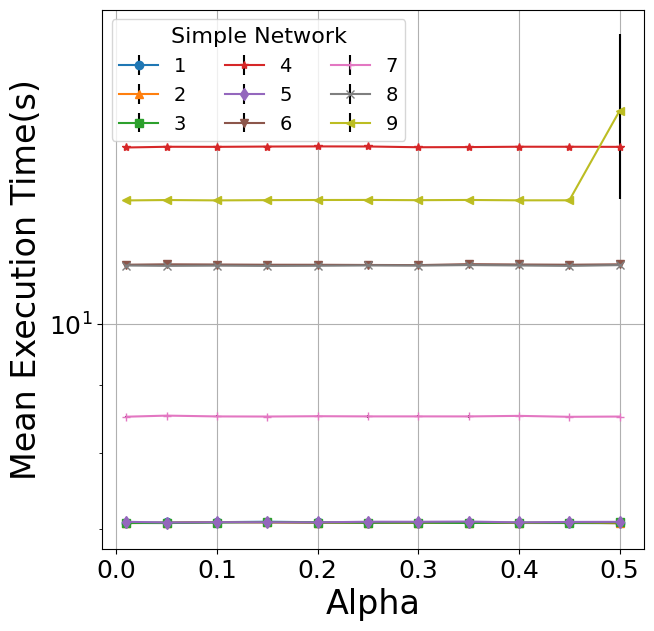

In [42]:
MVGC_Mean_Exe_Time = np.zeros((num_simple_networks, len(mvgc_alpha)))
MVGC_std_Exe_Time = np.zeros((num_simple_networks, len(mvgc_alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(mvgc_alpha)):
        MVGC_Mean_Exe_Time[n,a] = np.mean(np.array(mvgc_simple_net_execution_time[n])[:,a])
        MVGC_std_Exe_Time[n,a] = np.std(np.array(mvgc_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(mvgc_alpha, MVGC_Mean_Exe_Time[n,:], MVGC_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### MVGC Performance

In [43]:
mvgc_adj_TPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_FPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_Recall_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_Precision_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_F1_score_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]

mvgc_ori_TPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_FPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_Recall_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_Precision_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_F1_score_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]


for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        for a in range(0, len(mvgc_alpha)):
           
                true_graph_matrix = np.array(ground_truth_graph_matrix_all_networks[n])
                estimated_graph_matrix = np.array(mvgc_link_matrix_all_simple_net[n][r][a])-1
                adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(true_graph_matrix, estimated_graph_matrix)

                mvgc_adj_TPR_all_rep[n][r][a] = adjacency_TPR
                mvgc_adj_FPR_all_rep[n][r][a] = adjacency_FPR
                mvgc_adj_Recall_all_rep[n][r][a] = adjacency_Recall
                mvgc_adj_Precision_all_rep[n][r][a] = adjacency_Precision
                mvgc_adj_F1_score_all_rep[n][r][a] = adjacency_F1_score

                mvgc_ori_TPR_all_rep[n][r][a] = orientation_TPR
                mvgc_ori_FPR_all_rep[n][r][a] = orientation_FPR
                mvgc_ori_Recall_all_rep[n][r][a] = orientation_Recall
                mvgc_ori_Precision_all_rep[n][r][a] = orientation_Precision
                mvgc_ori_F1_score_all_rep[n][r][a] = orientation_F1_score

### Precision, Recall, F1 scores

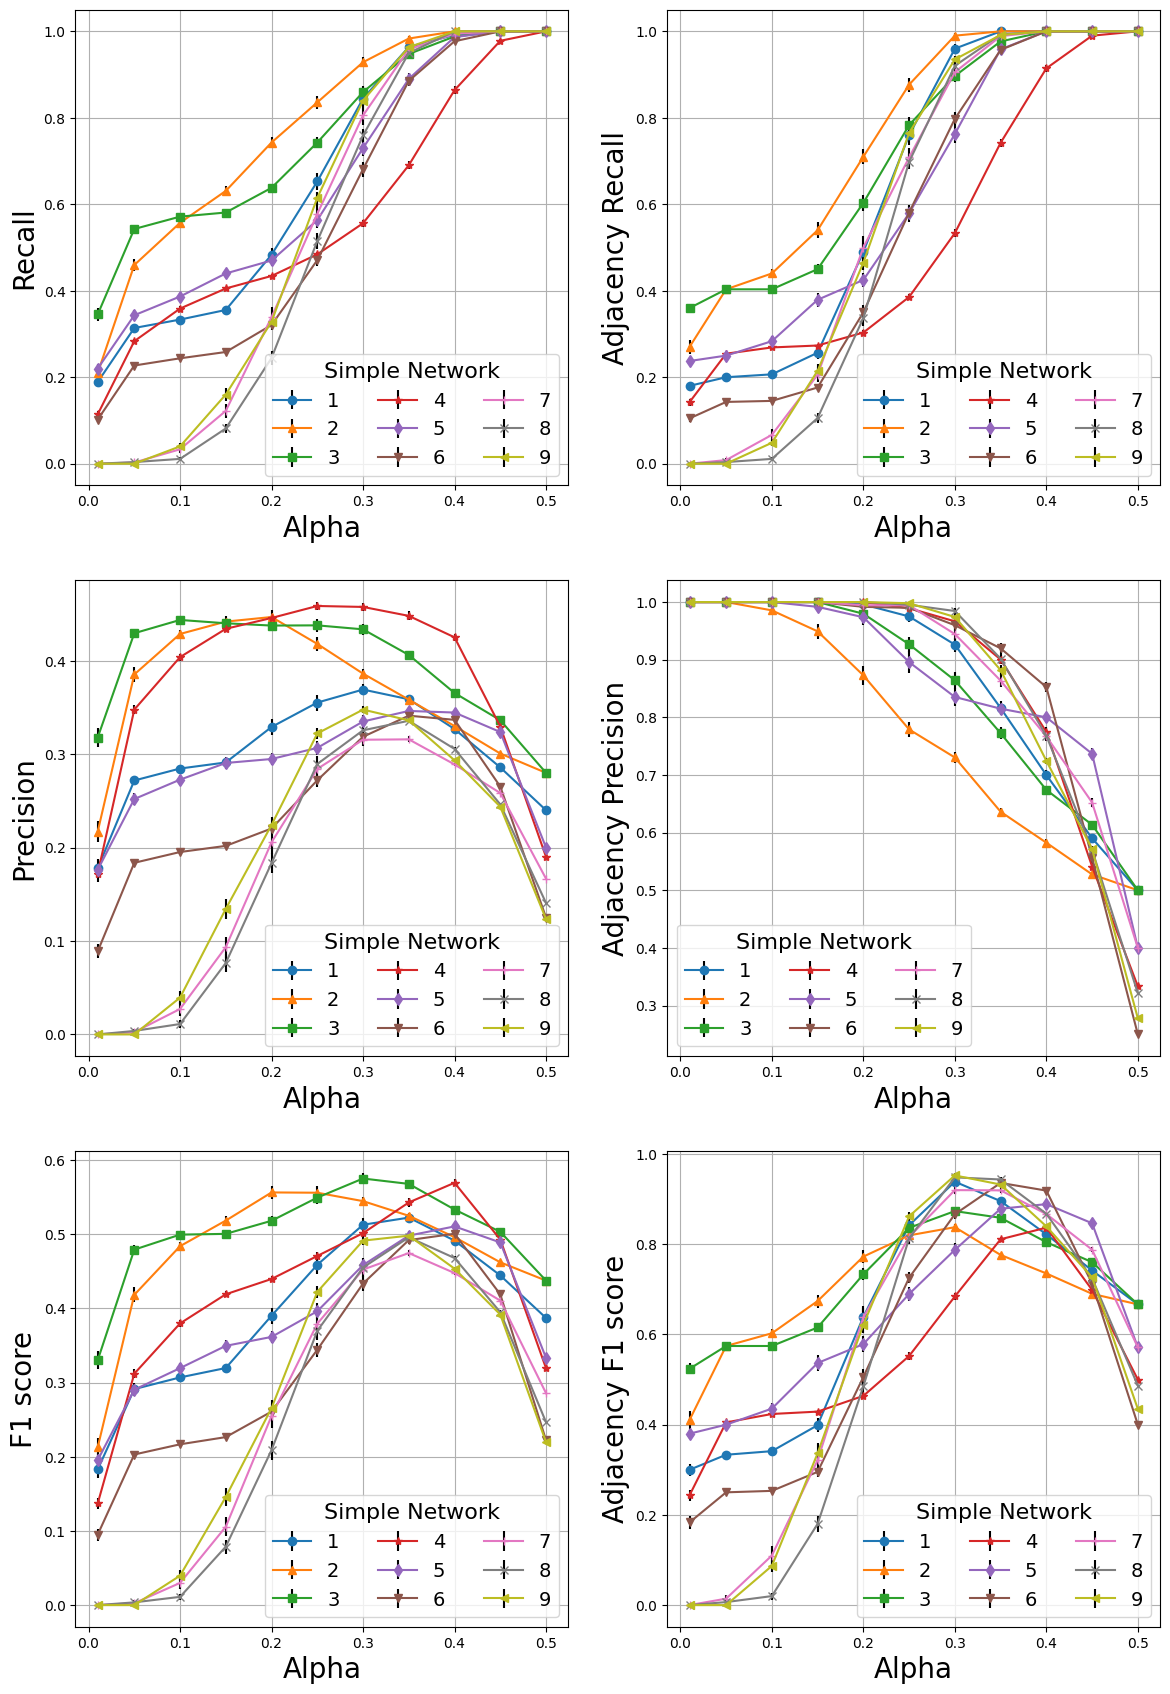

In [44]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14, 21))

mvgc_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
mvgc_best_alpha_adj_median = np.zeros((num_simple_networks,1))
mvgc_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
mvgc_best_alpha_ori_median = np.zeros((num_simple_networks,1))

for n in range(0, num_simple_networks):
    
    mvgc_adj_recall_mean = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_median = np.zeros_like(mvgc_alpha)

    mvgc_adj_precision_mean = np.zeros_like(mvgc_alpha) 
    mvgc_adj_precision_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_precision_median = np.zeros_like(mvgc_alpha) 

    mvgc_adj_F1_score_mean = np.zeros_like(mvgc_alpha) 
    mvgc_adj_F1_score_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_F1_score_median = np.zeros_like(mvgc_alpha) 

    mvgc_ori_recall_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_median = np.zeros_like(mvgc_alpha)

    mvgc_ori_precision_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_median = np.zeros_like(mvgc_alpha)

    mvgc_ori_F1_score_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_median = np.zeros_like(mvgc_alpha)

    for a in range(0,len(mvgc_alpha)):

        mvgc_adj_recall_mean[a] = np.mean(np.array(mvgc_adj_Recall_all_rep[n])[:,a])
        mvgc_adj_recall_std[a] = np.std(np.array(mvgc_adj_Recall_all_rep[n])[:,a])
        mvgc_adj_recall_median[a] = np.median(np.array(mvgc_adj_Recall_all_rep[n])[:,a])

        mvgc_adj_precision_mean[a] = np.mean(np.array(mvgc_adj_Precision_all_rep[n])[:,a])
        mvgc_adj_precision_std[a] = np.std(np.array(mvgc_adj_Precision_all_rep[n])[:,a])
        mvgc_adj_precision_median[a] = np.median(np.array(mvgc_adj_Precision_all_rep[n])[:,a])

        mvgc_adj_F1_score_mean[a] = np.mean(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])
        mvgc_adj_F1_score_std[a] = np.std(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])
        mvgc_adj_F1_score_median[a] = np.median(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])

        mvgc_ori_recall_mean[a] = np.mean(np.array(mvgc_ori_Recall_all_rep[n])[:,a])
        mvgc_ori_recall_std[a] = np.std(np.array(mvgc_ori_Recall_all_rep[n])[:,a])
        mvgc_ori_recall_median[a] = np.median(np.array(mvgc_ori_Recall_all_rep[n])[:,a])

        mvgc_ori_precision_mean[a] = np.mean(np.array(mvgc_ori_Precision_all_rep[n])[:,a])
        mvgc_ori_precision_std[a] = np.std(np.array(mvgc_ori_Precision_all_rep[n])[:,a])
        mvgc_ori_precision_median[a] = np.median(np.array(mvgc_ori_Precision_all_rep[n])[:,a])

        mvgc_ori_F1_score_mean[a] = np.mean(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])
        mvgc_ori_F1_score_std[a] = np.std(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])
        mvgc_ori_F1_score_median[a] = np.median(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])

    mvgc_best_alpha_adj_mean[n] = mvgc_alpha[np.argmax(mvgc_adj_F1_score_mean)]
    mvgc_best_alpha_adj_median[n] = mvgc_alpha[np.argmax(mvgc_adj_F1_score_median)]
    mvgc_best_alpha_ori_mean[n] = mvgc_alpha[np.argmax(mvgc_ori_F1_score_mean)]
    mvgc_best_alpha_ori_median[n] = mvgc_alpha[np.argmax(mvgc_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(mvgc_alpha, mvgc_adj_recall_mean, mvgc_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(mvgc_alpha, mvgc_ori_recall_mean, mvgc_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(mvgc_alpha, mvgc_adj_precision_mean, mvgc_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(mvgc_alpha, mvgc_ori_precision_mean, mvgc_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(mvgc_alpha, mvgc_adj_F1_score_mean, mvgc_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(mvgc_alpha, mvgc_ori_F1_score_mean, mvgc_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## Comparison

### Execution Time of All the Methods

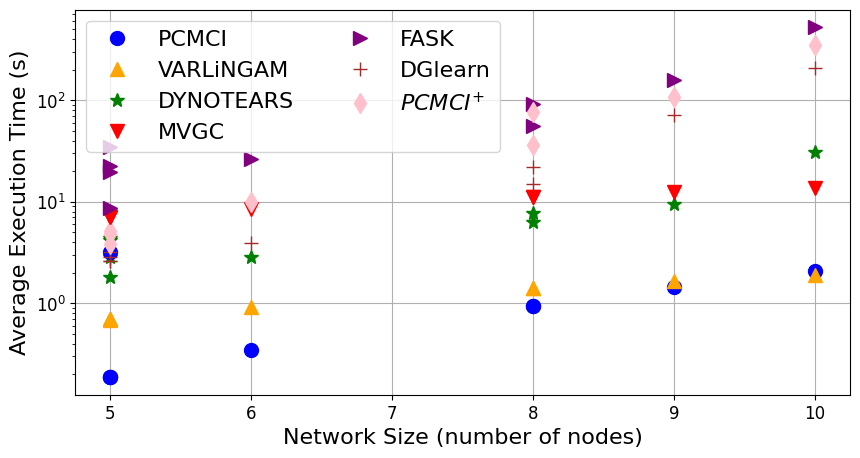

In [45]:
plt.figure(figsize = (10,5))

for n in range(0,num_simple_networks):
    plt.plot(net_size_all[n], PCMCI_Mean_Exe_Time[n,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]], 'o', markersize = 10, color = 'blue')
    plt.plot(net_size_all[n], Varlingam_Mean_Exe_Time[n,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]], '^', markersize = 10, color = 'orange')
    plt.plot(net_size_all[n], Dynotears_Mean_Exe_Time[n,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]], '*', markersize = 10, color = 'green')
    plt.plot(net_size_all[n], MVGC_Mean_Exe_Time[n,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]], 'v', markersize = 10 , color = 'red')
    plt.plot(net_size_all[n], FASK_Mean_Exe_Time[n,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]], '>', markersize = 10 , color = 'purple')
    plt.plot(net_size_all[n], Dglearn_Mean_Exe_Time[n,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]], '+', markersize = 10, color = 'brown')
    plt.plot(net_size_all[n], PCMCIplus_Mean_Exe_Time[n,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]], 'd', markersize = 10, color = 'pink')

    plt.yscale('log')
    plt.xlabel('Network Size (number of nodes)', fontsize = 16 )
    plt.ylabel('Average Execution Time (s)', fontsize = 16)
    plt.grid()

    plt.legend(['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$'], fontsize = 16, ncols = 2, loc = 'best')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)


### Distribution of F1 scores at best hyperparameter value (for each network)

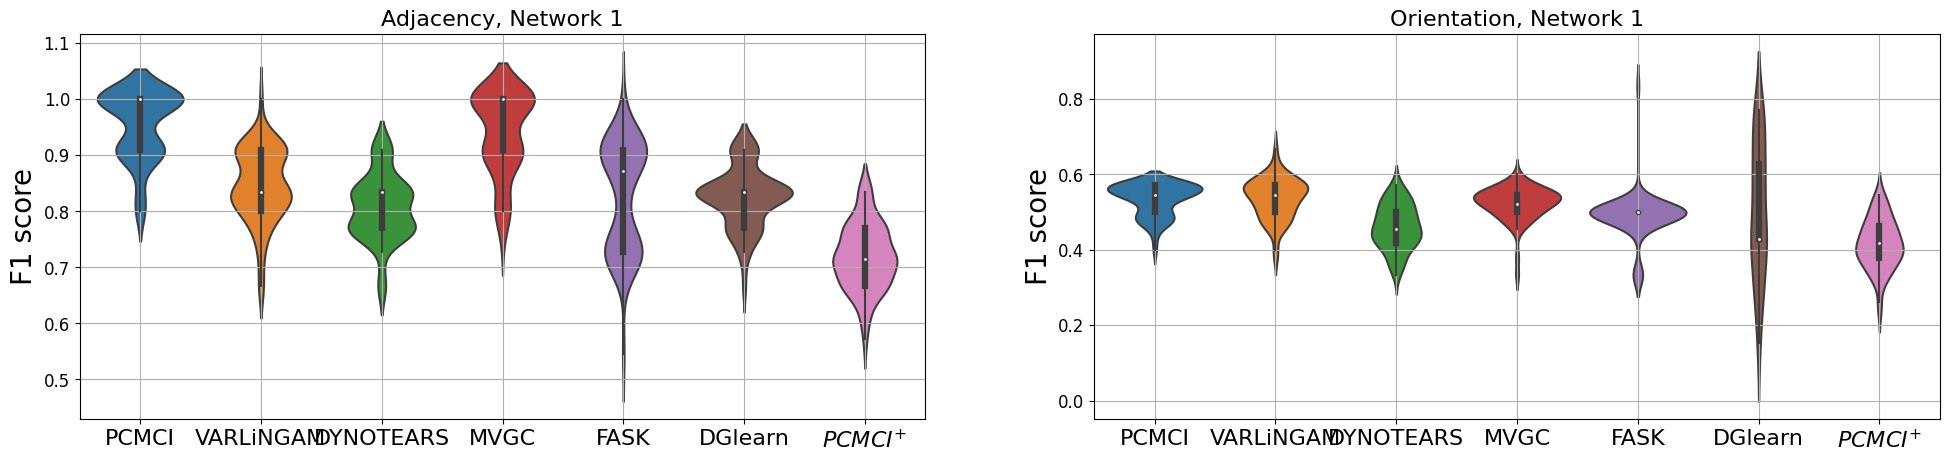

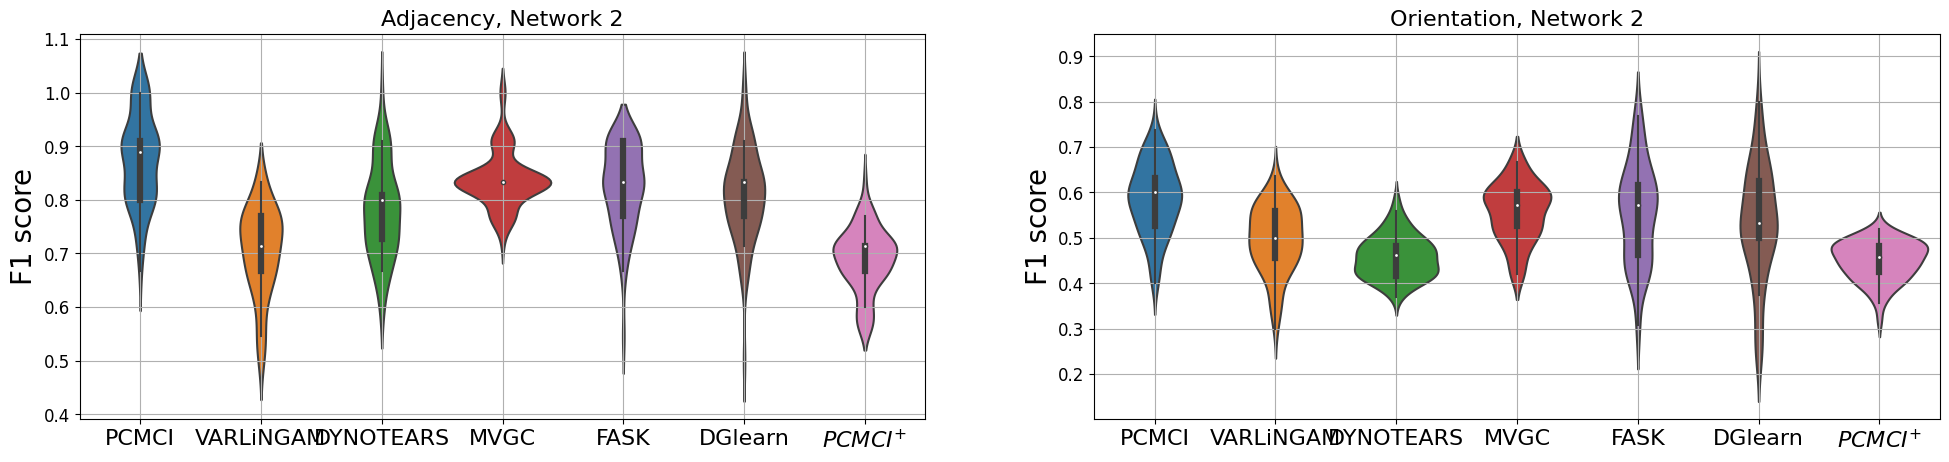

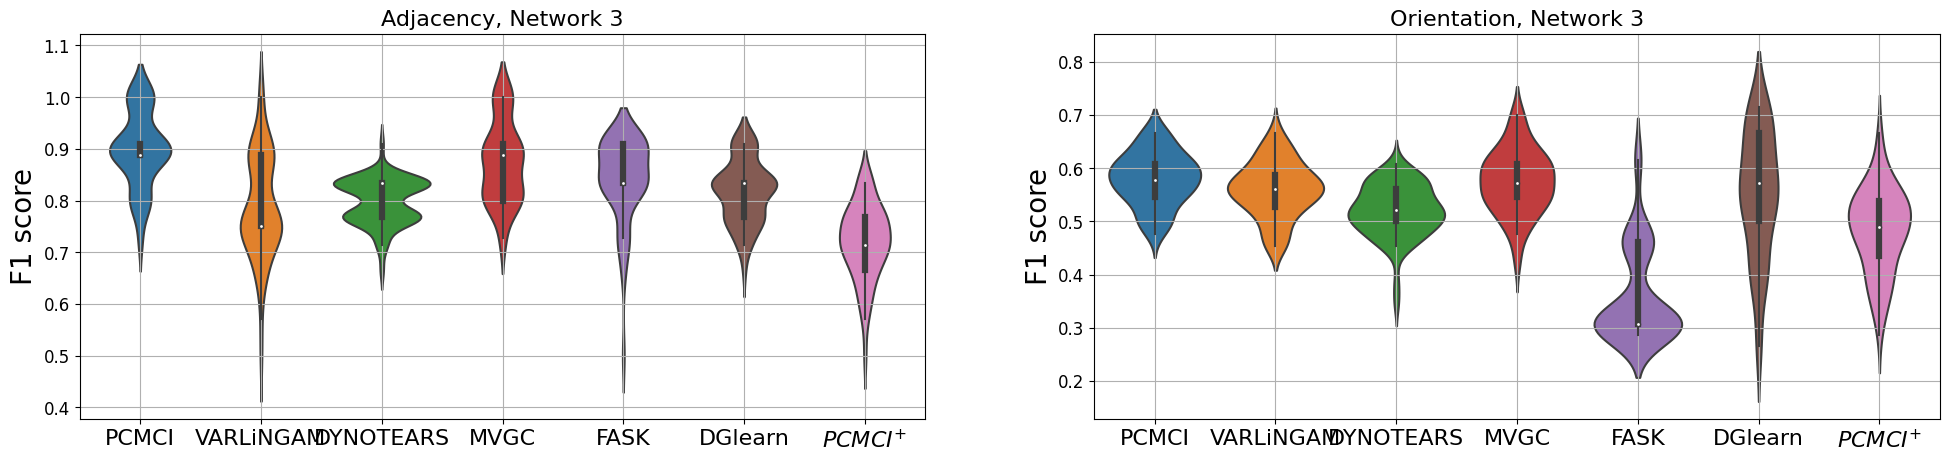

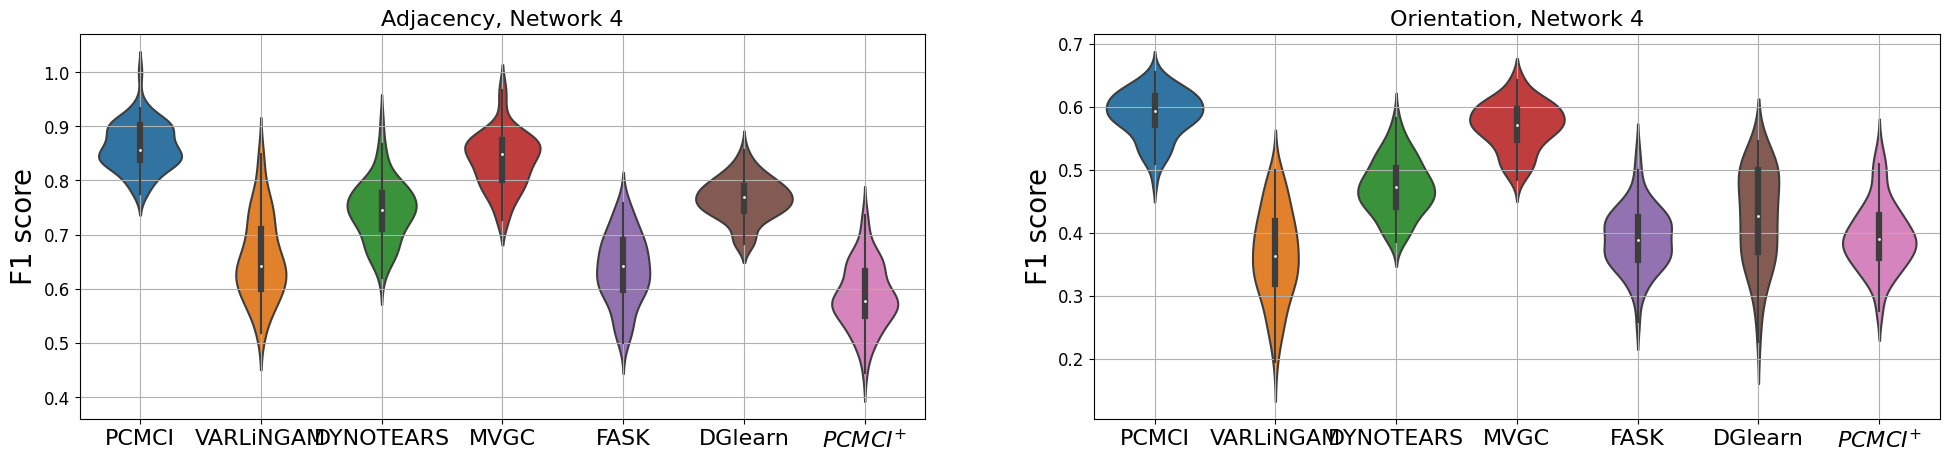

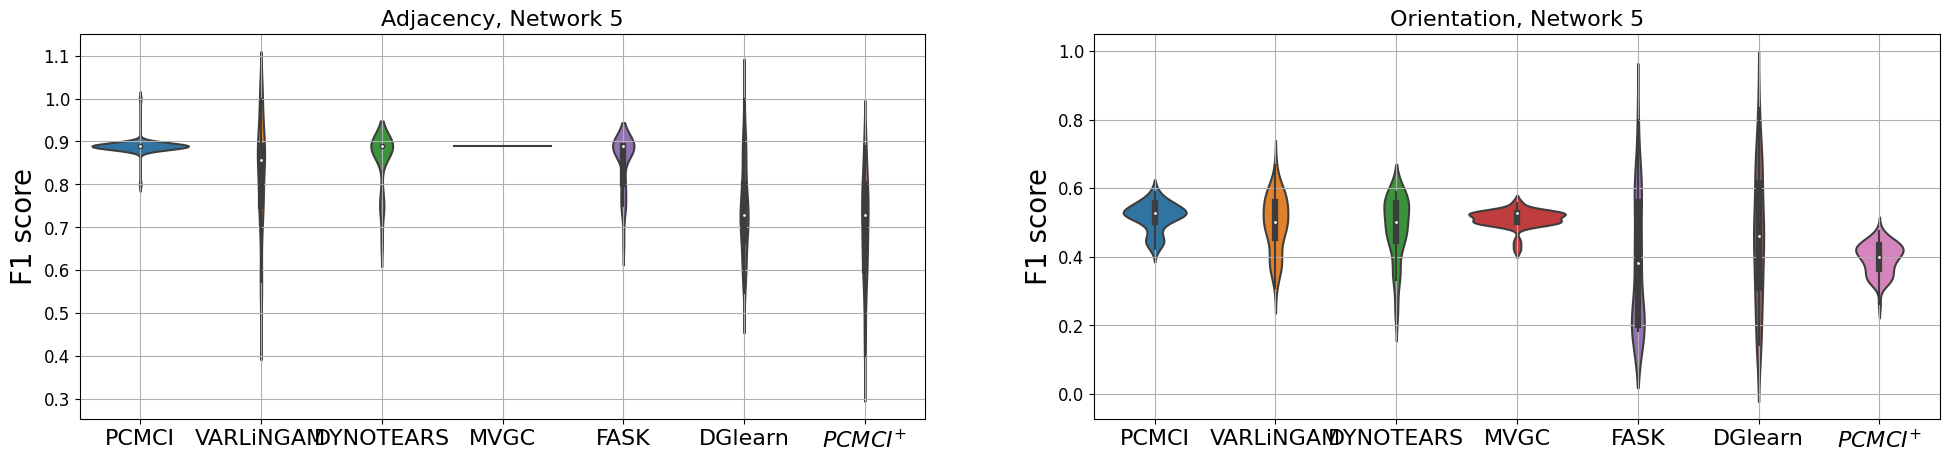

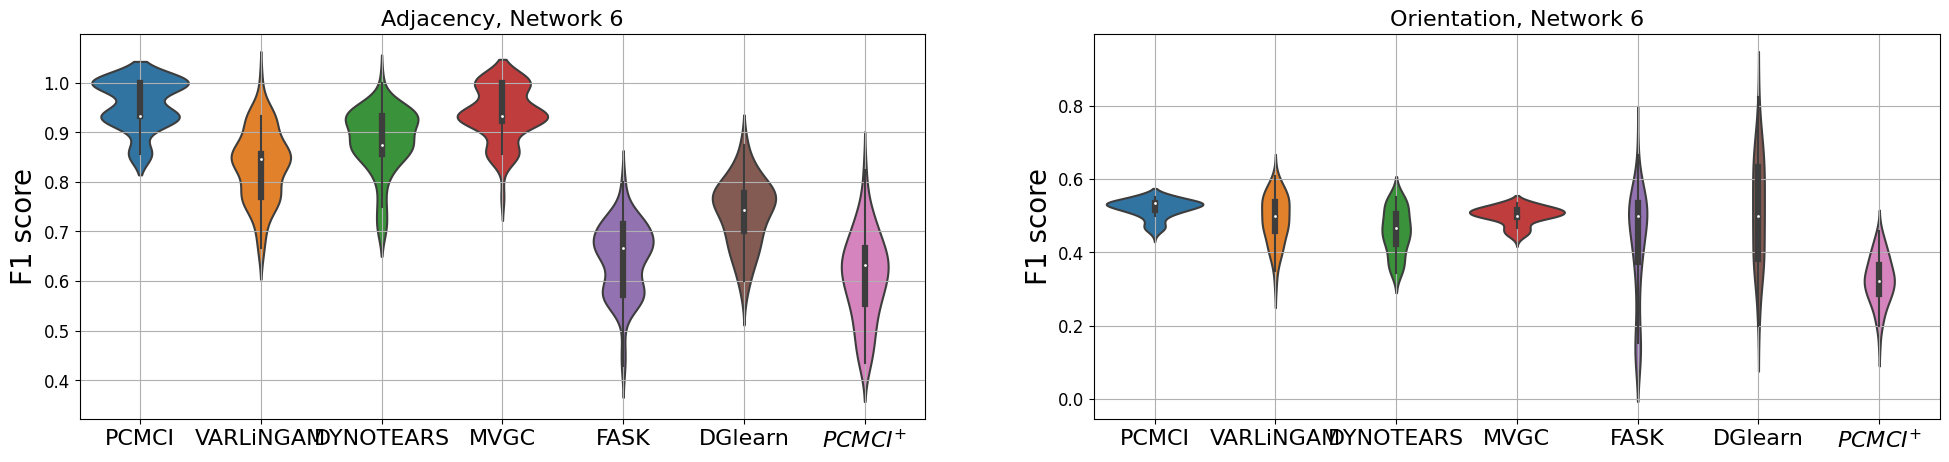

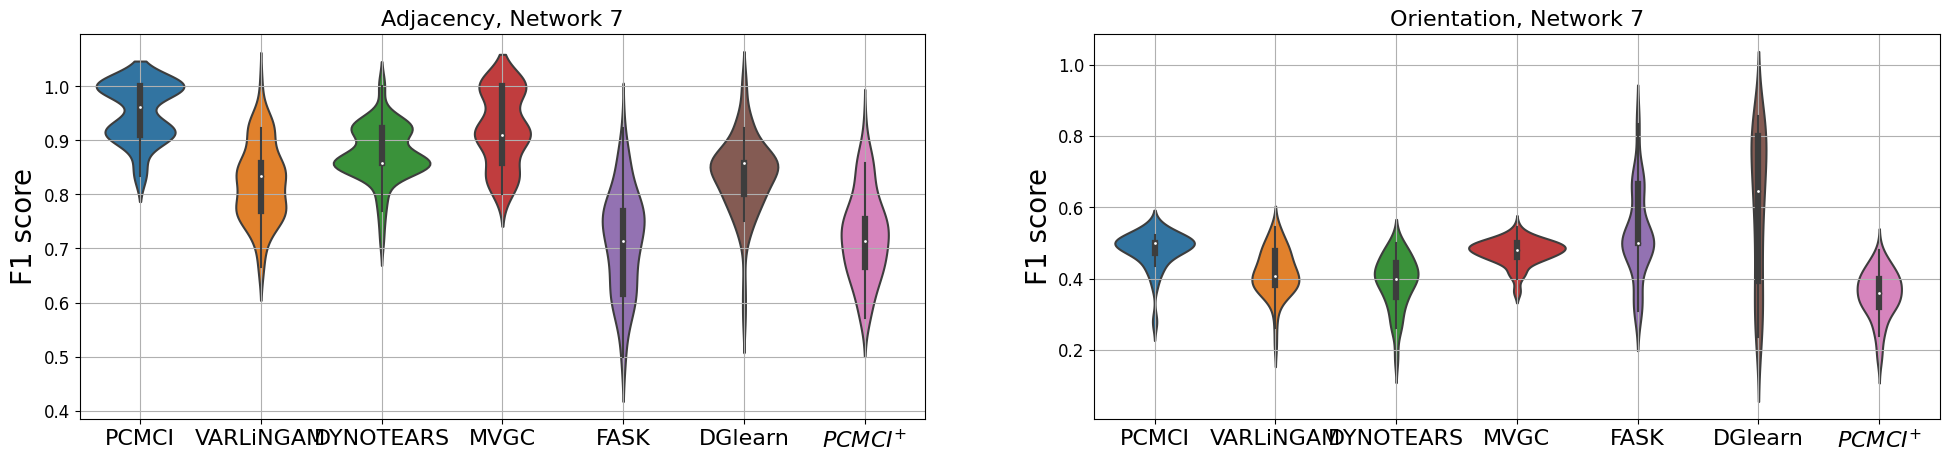

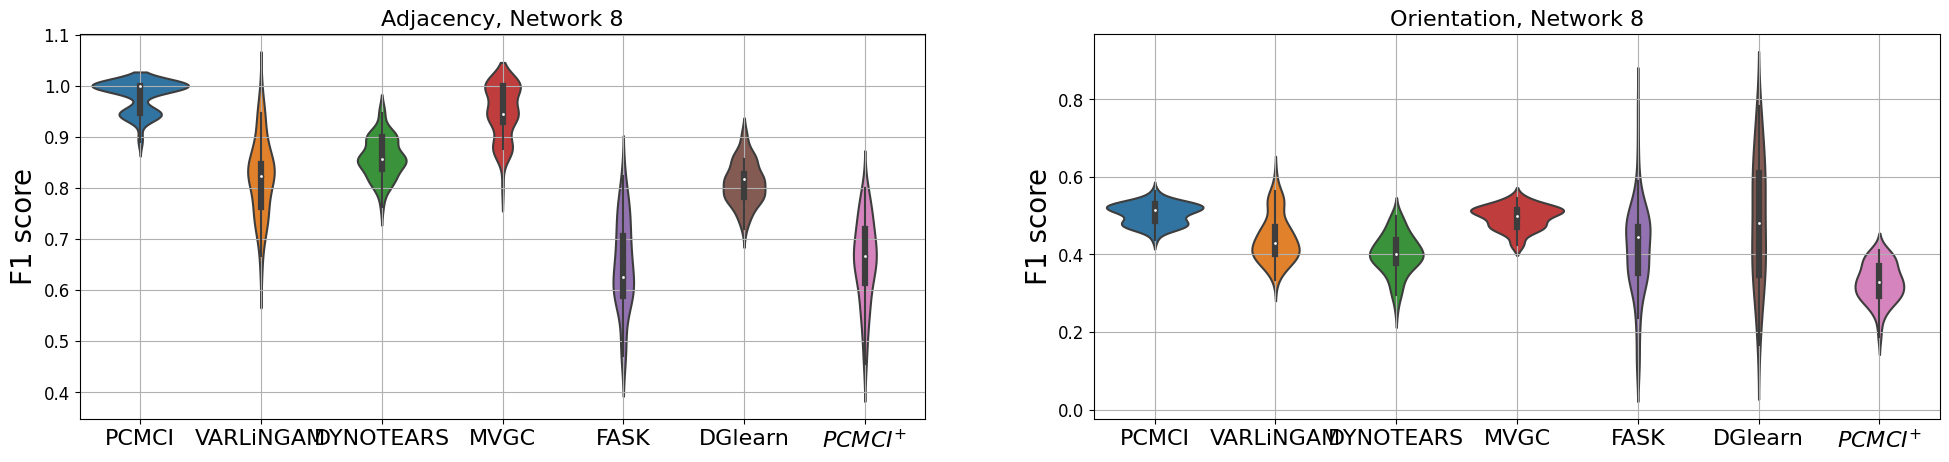

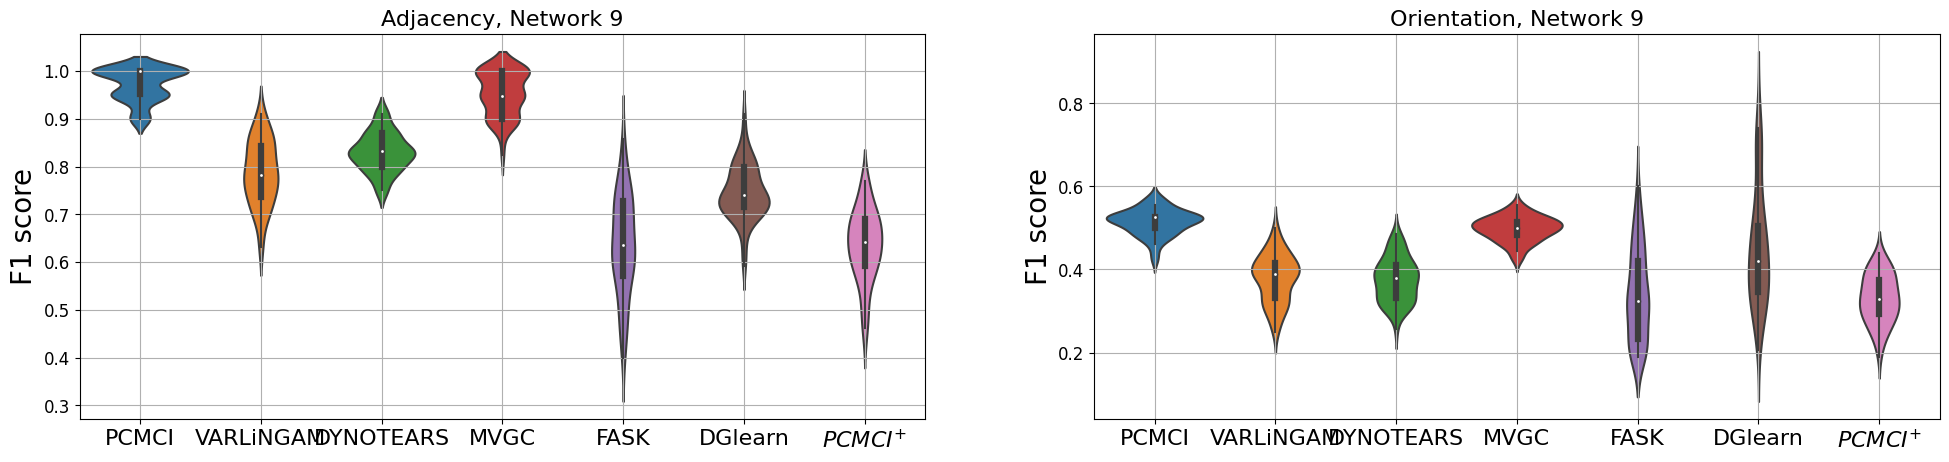

In [46]:

labels = ['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$']

for n in range(0,num_simple_networks):
    
    plt.figure(figsize = (24,5))

    adj_all_methods_F1_score_dist  = []
    ax1= plt.subplot(1,2,1)
    adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(varlingam_adj_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(dynotears_adj_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(mvgc_adj_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(fask_adj_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(dglearn_adj_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_adj_mean[n][0])[0][0]])

    parts = sb.violinplot(adj_all_methods_F1_score_dist)

    ax1.set_xticklabels(labels,fontsize = 16)

    plt.ylabel('F1 score',fontsize = 20)
    plt.title('Adjacency, Network %d'%(n+1),fontsize = 16)
    plt.yticks(fontsize = 12)
    plt.grid()


    ax2 = plt.subplot(1,2,2)
    ori_all_methods_F1_score_dist  = []
    ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(varlingam_ori_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(dynotears_ori_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(mvgc_ori_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(fask_ori_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(dglearn_ori_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]])

    parts = sb.violinplot(ori_all_methods_F1_score_dist)

    ax2.set_xticklabels(labels,fontsize = 16)
    plt.yticks(fontsize = 12)
    plt.grid()
    plt.ylabel('F1 score',fontsize = 20)
    plt.title('Orientation, Network %d'%(n+1),fontsize = 16)


### Distribution of F1 scores for all the simple networks combined

Text(0, 0.5, 'Adjacency F1 score')

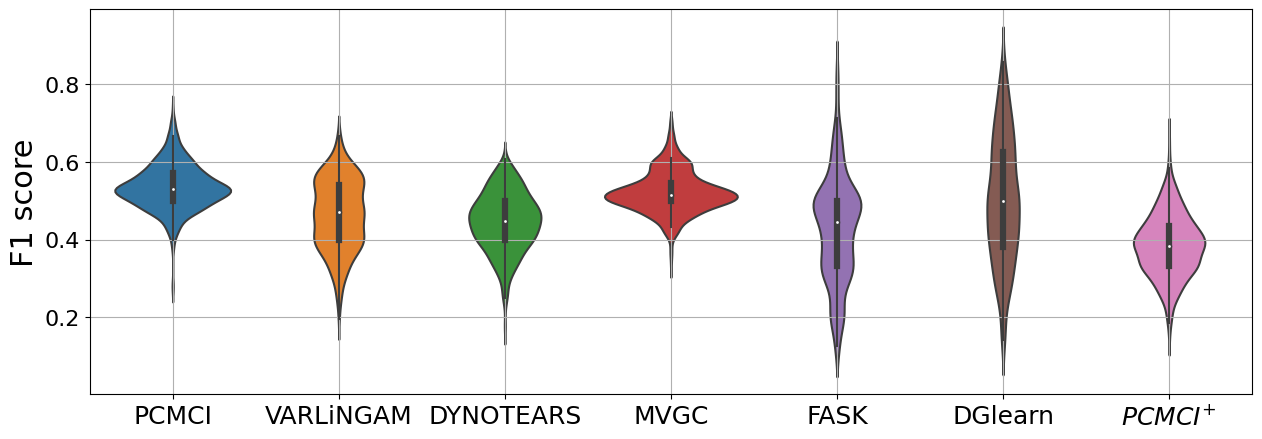

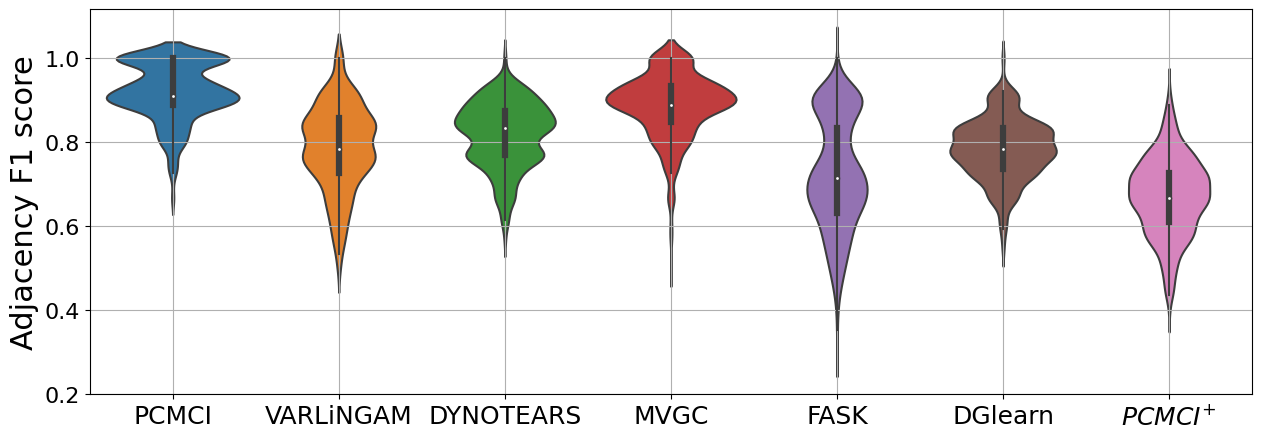

In [47]:
# all_colors = ['blue', 'orange', 'green', 'red', 'purple']
labels = ['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$']

fask_all_f1_ori = np.array([])
varlingam_all_f1_ori= np.array([])
dynotears_all_f1_ori= np.array([])
mvgc_all_f1_ori= np.array([])
pcmci_all_f1_ori= np.array([])
dglearn_all_f1_ori= np.array([])
pcmciplus_all_f1_ori= np.array([])

fask_all_f1_adj = np.array([])
varlingam_all_f1_adj = np.array([])
dynotears_all_f1_adj = np.array([])
mvgc_all_f1_adj = np.array([])
pcmci_all_f1_adj = np.array([])
dglearn_all_f1_adj = np.array([])
pcmciplus_all_f1_adj = np.array([])


for n in range(0,num_simple_networks):
    
    fask_all_f1_ori = np.concatenate((fask_all_f1_ori,np.array(fask_ori_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]]))
    varlingam_all_f1_ori = np.concatenate((varlingam_all_f1_ori,np.array(varlingam_ori_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]]))
    dynotears_all_f1_ori = np.concatenate((dynotears_all_f1_ori,np.array(dynotears_ori_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]]))
    mvgc_all_f1_ori = np.concatenate((mvgc_all_f1_ori,np.array(mvgc_ori_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]]))
    pcmci_all_f1_ori = np.concatenate((pcmci_all_f1_ori,np.array(pcmci_ori_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]]))
    dglearn_all_f1_ori = np.concatenate((dglearn_all_f1_ori,np.array(dglearn_ori_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]]))
    pcmciplus_all_f1_ori = np.concatenate((pcmciplus_all_f1_ori,np.array(pcmciplus_ori_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]]))


    fask_all_f1_adj = np.concatenate((fask_all_f1_adj,np.array(fask_adj_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]]))
    varlingam_all_f1_adj = np.concatenate((varlingam_all_f1_adj,np.array(varlingam_adj_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]]))
    dynotears_all_f1_adj = np.concatenate((dynotears_all_f1_adj,np.array(dynotears_adj_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]]))
    mvgc_all_f1_adj = np.concatenate((mvgc_all_f1_adj,np.array(mvgc_adj_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]]))
    pcmci_all_f1_adj = np.concatenate((pcmci_all_f1_adj,np.array(pcmci_adj_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]]))
    dglearn_all_f1_adj = np.concatenate((dglearn_all_f1_adj,np.array(dglearn_adj_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]]))
    pcmciplus_all_f1_adj = np.concatenate((pcmciplus_all_f1_adj,np.array(pcmciplus_adj_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_adj_mean[n][0])[0][0]]))

all_methods_f1_ori = [pcmci_all_f1_ori,varlingam_all_f1_ori,dynotears_all_f1_ori,mvgc_all_f1_ori,fask_all_f1_ori, dglearn_all_f1_ori, pcmciplus_all_f1_ori]
all_methods_f1_adj = [pcmci_all_f1_adj,varlingam_all_f1_adj,dynotears_all_f1_adj,mvgc_all_f1_adj,fask_all_f1_adj , dglearn_all_f1_adj, pcmciplus_all_f1_adj]


plt.figure(figsize = (15,5))
ax = plt.subplot()
parts = sb.violinplot(all_methods_f1_ori)

ax.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('F1 score',fontsize = 22)

plt.figure(figsize = (15,5))
ax = plt.subplot()
parts = sb.violinplot(all_methods_f1_adj)

ax.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('Adjacency F1 score',fontsize = 22)

##### Statistical Test between distributions of F1 scores for different methods

In [48]:
## F1 score
f1_score_pcmci_dynotears = sp.stats.wilcoxon(pcmci_all_f1_ori, dynotears_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_varlingam = sp.stats.wilcoxon(pcmci_all_f1_ori, varlingam_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_mvgc = sp.stats.wilcoxon(pcmci_all_f1_ori, mvgc_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_fask =  sp.stats.wilcoxon(pcmci_all_f1_ori, fask_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_dglearn = sp.stats.wilcoxon(pcmci_all_f1_ori, dglearn_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_pcmciplus = sp.stats.wilcoxon(pcmci_all_f1_ori, pcmciplus_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")

## Adjacency F1 score

adj_f1_score_pcmci_dynotears = sp.stats.wilcoxon(pcmci_all_f1_adj, dynotears_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_varlingam = sp.stats.wilcoxon(pcmci_all_f1_adj, varlingam_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_mvgc = sp.stats.wilcoxon(pcmci_all_f1_adj, mvgc_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_fask =  sp.stats.wilcoxon(pcmci_all_f1_adj, fask_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_dglearn = sp.stats.wilcoxon(pcmci_all_f1_adj, dglearn_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_pcmciplus = sp.stats.wilcoxon(pcmci_all_f1_adj, pcmciplus_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")


print('pcmci-dynotears',f1_score_pcmci_dynotears.zstatistic, f1_score_pcmci_dynotears.pvalue )
print('pcmci-varlingam',f1_score_pcmci_varlingam.zstatistic, f1_score_pcmci_varlingam.pvalue )
print('pcmci-mvgc',f1_score_pcmci_mvgc.zstatistic, f1_score_pcmci_mvgc.pvalue )
print('pcmci-fask',f1_score_pcmci_fask.zstatistic, f1_score_pcmci_fask.pvalue )
print('pcmci-dglearn',f1_score_pcmci_dglearn.zstatistic, f1_score_pcmci_dglearn.pvalue)
print('pcmci-pcmciplus',f1_score_pcmci_pcmciplus.zstatistic, f1_score_pcmci_pcmciplus.pvalue)


print('pcmci-dynotears',adj_f1_score_pcmci_dynotears.zstatistic, adj_f1_score_pcmci_dynotears.pvalue)
print('pcmci-varlingam',adj_f1_score_pcmci_varlingam.zstatistic, adj_f1_score_pcmci_varlingam.pvalue )
print('pcmci-mvgc',adj_f1_score_pcmci_mvgc.zstatistic, adj_f1_score_pcmci_mvgc.pvalue )
print('pcmci-fask',adj_f1_score_pcmci_fask.zstatistic, adj_f1_score_pcmci_fask.pvalue )
print('pcmci-dglearn',adj_f1_score_pcmci_dglearn.zstatistic, adj_f1_score_pcmci_dglearn.pvalue)
print('pcmci-pcmciplus',adj_f1_score_pcmci_pcmciplus.zstatistic, adj_f1_score_pcmci_pcmciplus.pvalue)


pcmci-dynotears 17.957722936006896 2.087952833678051e-72
pcmci-varlingam 13.529378943015905 5.2453084921676517e-42
pcmci-mvgc 8.943212352244865 1.8900919462365978e-19
pcmci-fask 14.077606107366718 2.6073246556330446e-45
pcmci-dglearn 4.975731177957602 3.250090250937419e-07
pcmci-pcmciplus 19.702197817257797 1.032300794858497e-86
pcmci-dynotears 17.899791083659128 5.91825483133425e-72
pcmci-varlingam 18.300802640516036 4.0769373274699245e-75
pcmci-mvgc 11.32159587416386 5.129358692024806e-30
pcmci-fask 17.704587294041186 1.9325171021623945e-70
pcmci-dglearn 18.532772472420483 5.6173195297247625e-77
pcmci-pcmciplus 19.904536678573205 1.8585627439004963e-88
